In [1]:
import pandas as pd
import numpy as np
import pickle
from tabulate import tabulate
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,roc_auc_score, classification_report, 
    confusion_matrix, ConfusionMatrixDisplay, roc_curve
)
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import (
    RandomForestClassifier, StackingClassifier, GradientBoostingClassifier, 
    HistGradientBoostingClassifier, AdaBoostClassifier
)
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.base import BaseEstimator, ClassifierMixin

from interpret.glassbox import ExplainableBoostingClassifier 
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from ngboost import NGBClassifier
from ngboost.distns import Bernoulli 
from snapml import BoostingMachineClassifier  
from pytorch_tabnet.tab_model import TabNetClassifier

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from skorch import NeuralNetClassifier
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from tab_transformer_pytorch import TabTransformer 
from tab_transformer_pytorch import FTTransformer

2025-04-19 11:52:42.006352: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745038362.022705   25915 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745038362.026535   25915 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-19 11:52:42.041955: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
df = pd.read_csv('data/cleaned_data.csv')
cols_to_keep = ['age', 
                'height',
                'weight',
                'systolic', 
                'diastolic',
                'pulse_pressure',
                'gender',
                'cholesterol', 
                'gluc',
                'smoke', 
                'alco', 
                'active',
                'cardio'
                ]

df = df[cols_to_keep]

In [3]:
X = df.drop('cardio', axis=1)
y = df['cardio']

label_mapping = {0: 'Healthy', 1: 'Cardio Risk'}
target_names = [label_mapping[label] for label in y.unique()]

numerical_features = ['age', 'height', 'weight', 'systolic', 'diastolic', 'pulse_pressure']
ordinal_features = ['cholesterol', 'gluc']
binary_features = ['gender', 'smoke', 'alco', 'active']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features)
    ],
    remainder='passthrough'
)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

# Catatan: ColumnTransformer dengan remainder='passthrough' akan mengubah urutan kolom.
# Fitur yang discaling akan berada di awal, kemudian sisanya.
# Untuk mendapatkan nama kolom kembali (opsional), kita bisa menyusun ulang nama kolom sebagai berikut.
passthrough_features = [col for col in X.columns if col not in numerical_features]
transformed_feature_names = numerical_features + passthrough_features

X_train_transformed_df = pd.DataFrame(X_train_transformed, columns=transformed_feature_names)
X_test_transformed_df = pd.DataFrame(X_test_transformed, columns=transformed_feature_names)
print("Contoh data train setelah scaling:")
print(X_train_transformed_df.head())

Contoh data train setelah scaling:
        age    height    weight  systolic  diastolic  pulse_pressure  gender  \
0 -0.431181 -0.580958  0.227592 -0.448449  -0.219513       -0.453476     0.0   
1  1.645896 -0.050963  0.146374 -0.448449  -1.522162        0.508610     0.0   
2 -1.766444  0.479031 -0.503370 -1.149304  -1.522162       -0.453476     0.0   
3 -1.469719  0.611530  1.933169  1.303690   1.734461        0.508610     1.0   
4 -0.134455  1.009026  0.146374 -0.448449  -0.219513       -0.453476     0.0   

   cholesterol  gluc  smoke  alco  active  
0          0.0   0.0    0.0   0.0     0.0  
1          0.0   0.0    0.0   0.0     0.0  
2          0.0   0.0    0.0   0.0     1.0  
3          0.0   0.0    1.0   1.0     1.0  
4          0.0   0.0    0.0   0.0     1.0  


In [4]:
x_train_np = np.array(X_train_transformed)
y_train_np = np.array(y_train)
x_test_np = np.array(X_test_transformed)
y_test_np = np.array(y_test)

In [5]:
class TabularDataset(Dataset):
    def __init__(self, X, categorical_indices, continuous_indices, targets):
        self.X = X
        self.categorical_indices = categorical_indices
        self.continuous_indices = continuous_indices
        self.targets = targets
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        row = self.X[idx]
        x_cont = row[self.continuous_indices].astype(np.float32)
        x_cat  = row[self.categorical_indices].astype(np.int64)
        target = np.array(self.targets[idx]).astype(np.float32)
        return x_cat, x_cont, target

class PyTorchClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, model, epochs=10, lr=1e-3, batch_size=32, device=None,
                continuous_indices=None, categorical_indices=None, classes_=None):
        self.model = model
        self.epochs = epochs
        self.lr = lr
        self.batch_size = batch_size
        self.device = device if device is not None else torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.continuous_indices = continuous_indices
        self.categorical_indices = categorical_indices
        self.classes_ = classes_ if classes_ is not None else []
    
    def fit(self, X, y):
        if self.continuous_indices is None or self.categorical_indices is None:
            raise ValueError("continuous_indices and categorical_indices must be provided")
        train_dataset = TabularDataset(X, self.categorical_indices, self.continuous_indices, y)
        train_loader = DataLoader(train_dataset, batch_size=self.batch_size, shuffle=True)
        self.model.to(self.device)
        self.model.train()
        criterion = torch.nn.BCEWithLogitsLoss()
        optimizer = torch.optim.Adam(self.model.parameters(), lr=self.lr)
        for epoch in range(self.epochs):
            epoch_loss = 0.0
            for batch in train_loader:
                x_cat, x_cont, targets = batch
                x_cat = x_cat.to(self.device)
                x_cont = x_cont.to(self.device)
                targets = targets.to(self.device)
                optimizer.zero_grad()
                outputs = self.model(x_cat, x_cont)
                loss = criterion(outputs, targets.float().unsqueeze(1))
                loss.backward()
                optimizer.step()
                epoch_loss += loss.item()
            avg_loss = epoch_loss / len(train_loader)
            print(f"[Wrapper] Epoch {epoch+1}/{self.epochs}, Loss: {avg_loss:.4f}")
        self.classes_ = np.unique(y)
        return self

    def predict(self, X):
        self.model.eval()
        dummy_targets = np.zeros(len(X))
        dataset = TabularDataset(X, self.categorical_indices, self.continuous_indices, dummy_targets)
        loader = DataLoader(dataset, batch_size=self.batch_size, shuffle=False)
        preds = []
        with torch.no_grad():
            for batch in loader:
                x_cat, x_cont, _ = batch
                x_cat = x_cat.to(self.device)
                x_cont = x_cont.to(self.device)
                outputs = self.model(x_cat, x_cont)
                probs = torch.sigmoid(outputs)
                preds.append((probs.cpu().numpy() >= 0.5).astype(int))
        preds = np.concatenate(preds).squeeze()
        return preds

    def predict_proba(self, X):
        self.model.eval()
        dummy_targets = np.zeros(len(X))
        dataset = TabularDataset(X, self.categorical_indices, self.continuous_indices, dummy_targets)
        loader = DataLoader(dataset, batch_size=self.batch_size, shuffle=False)
        probas = []
        with torch.no_grad():
            for batch in loader:
                x_cat, x_cont, _ = batch
                x_cat = x_cat.to(self.device)
                x_cont = x_cont.to(self.device)
                outputs = self.model(x_cat, x_cont)
                probs = torch.sigmoid(outputs)
                probas.append(probs.cpu().numpy())
        probas = np.concatenate(probas).squeeze()
        return np.vstack([1 - probas, probas]).T

    def get_params(self, deep=True):
        return {
            "model": self.model,
            "epochs": self.epochs,
            "lr": self.lr,
            "batch_size": self.batch_size,
            "device": self.device,
            "continuous_indices": self.continuous_indices,
            "categorical_indices": self.categorical_indices,
            "classes_": self.classes_
        }
    
    def set_params(self, **params):
        for key, value in params.items():
            setattr(self, key, value)
        return self

In [6]:
def evaluate_model(model, model_name="", framework="", 
                   x_train=None, y_train=None, x_test=None, y_test=None,
                   continuous_indices=None, categorical_indices=None,
                   batch_size=32, device=None, epochs=10, **kwargs):

    if framework.lower() not in ["tab transformer", "ft transformer"]:
        if x_train is None or y_train is None or x_test is None or y_test is None:
            raise ValueError("Incomplete parameters. Provide x_train, y_train, x_test, y_test for scikit-learn evaluation.")

        model.fit(x_train, y_train)
        
        y_pred_test = model.predict(x_test)
        y_proba_test = model.predict_proba(x_test)
        y_probs_test = y_proba_test[:, 1] if y_proba_test.ndim > 1 and y_proba_test.shape[1] > 1 else y_proba_test[:, 0]
        
        y_pred_train = model.predict(x_train)
        y_proba_train = model.predict_proba(x_train)
        y_probs_train = y_proba_train[:, 1] if y_proba_train.ndim > 1 and y_proba_train.shape[1] > 1 else y_proba_train[:, 0]
        
        test_accuracy  = accuracy_score(y_test, y_pred_test)
        test_auc       = roc_auc_score(y_test, y_probs_test)
        train_accuracy = accuracy_score(y_train, y_pred_train)
        train_auc      = roc_auc_score(y_train, y_probs_train)
        
        test_report_dict = classification_report(y_test, y_pred_test, output_dict=True)
        test_precision = test_report_dict['weighted avg']['precision']
        test_recall    = test_report_dict['weighted avg']['recall']
        test_f1        = test_report_dict['weighted avg']['f1-score']
        
        train_report_dict = classification_report(y_train, y_pred_train, output_dict=True)
        train_precision = train_report_dict['weighted avg']['precision']
        train_recall    = train_report_dict['weighted avg']['recall']
        train_f1        = train_report_dict['weighted avg']['f1-score']
    
    elif framework.lower() in ["tab transformer", "ft transformer"]:
        train_loader = kwargs.get("train_loader")
        test_loader  = kwargs.get("test_loader")
        
        if train_loader is None or test_loader is None:
            if x_train is None or y_train is None or x_test is None or y_test is None:
                raise ValueError("Incomplete parameters. Provide either train_loader, test_loader, device or raw x_train, y_train, x_test, y_test along with index information.")
            
            if continuous_indices is None:
                continuous_indices = list(range(len(numerical_features)))
            if categorical_indices is None:
                categorical_indices = list(range(len(numerical_features), len(transformed_feature_names)))
            if device is None:
                device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
            
            train_dataset = TabularDataset(x_train, categorical_indices, continuous_indices, y_train)
            test_dataset  = TabularDataset(x_test, categorical_indices, continuous_indices, y_test)
            train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
            test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
        
        if device is None:
            device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        
        model.to(device)
        criterion = torch.nn.BCEWithLogitsLoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
        model.train()
        for epoch in range(epochs):
            epoch_loss = 0.0
            for batch in train_loader:
                x_cat, x_cont, targets = batch
                x_cat, x_cont, targets = x_cat.to(device), x_cont.to(device), targets.to(device)
                
                optimizer.zero_grad()
                outputs = model(x_cat, x_cont)
                loss = criterion(outputs, targets.float().unsqueeze(1))
                loss.backward()
                optimizer.step()
                epoch_loss += loss.item()
            avg_epoch_loss = epoch_loss / len(train_loader)
            print(f"Epoch {epoch+1}/{epochs}, Training Loss: {avg_epoch_loss:.4f}")
        
        model.eval()
        all_preds_test, all_targets_test, test_losses = [], [], []
        with torch.no_grad():
            for batch in test_loader:
                x_cat, x_cont, targets = batch
                x_cat, x_cont, targets = x_cat.to(device), x_cont.to(device), targets.to(device)
                outputs = model(x_cat, x_cont)
                loss = criterion(outputs, targets.float().unsqueeze(1))
                test_losses.append(loss.item())
                probs = torch.sigmoid(outputs)
                all_preds_test.append(probs.cpu().numpy())
                all_targets_test.append(targets.cpu().numpy())
        avg_test_loss = np.mean(test_losses)
        all_preds_test   = np.concatenate(all_preds_test).squeeze()
        all_targets_test = np.concatenate(all_targets_test).squeeze()
        y_pred_test = (all_preds_test >= 0.5).astype(int)
        
        test_accuracy  = accuracy_score(all_targets_test, y_pred_test)
        test_auc       = roc_auc_score(all_targets_test, all_preds_test)
        
        test_report_dict = classification_report(all_targets_test, y_pred_test, output_dict=True)
        test_precision = test_report_dict['weighted avg']['precision']
        test_recall    = test_report_dict['weighted avg']['recall']
        test_f1        = test_report_dict['weighted avg']['f1-score']
        
        all_preds_train, all_targets_train = [], []
        with torch.no_grad():
            for batch in train_loader:
                x_cat, x_cont, targets = batch
                x_cat, x_cont = x_cat.to(device), x_cont.to(device)
                outputs = model(x_cat, x_cont)
                probs = torch.sigmoid(outputs)
                all_preds_train.append(probs.cpu().numpy())
                all_targets_train.append(targets.cpu().numpy())
        all_preds_train   = np.concatenate(all_preds_train).squeeze()
        all_targets_train = np.concatenate(all_targets_train).squeeze()
        y_pred_train = (all_preds_train >= 0.5).astype(int)
        train_accuracy = accuracy_score(all_targets_train, y_pred_train)
        train_auc      = roc_auc_score(all_targets_train, all_preds_train)
        
        train_report_dict = classification_report(all_targets_train, y_pred_train, output_dict=True)
        train_precision = train_report_dict['weighted avg']['precision']
        train_recall    = train_report_dict['weighted avg']['recall']
        train_f1        = train_report_dict['weighted avg']['f1-score']
        
    else:
        raise ValueError("Framework harus 'ml' atau 'dl'.")
    
    data = [
        ["Test", f"{int(test_accuracy * 100 * 100) / 100:.2f}%", f"{test_auc:.4f}"],
        ["Train", f"{int(train_accuracy * 100 * 100) / 100:.2f}%", f"{train_auc:.4f}"]
    ]
    headers = ["", "Accuracy", "AUC Score"]
    
    print(f"\n=== {model_name} ===\n")
    print(tabulate(data, headers=headers, tablefmt="grid"))
    print("\nOverfitting Check :")
    if train_accuracy > test_accuracy + 0.05 or train_auc > test_auc + 0.05:
        print("The model might be overfitting.")
    else:
        print("No significant signs of overfitting.\n")
    
    return {
        'model_name': model_name,
        'train_accuracy': train_accuracy,
        'train_precision': train_precision,
        'train_recall': train_recall,
        'train_f1': train_f1,
        'test_accuracy': test_accuracy,
        'test_precision': test_precision,
        'test_recall': test_recall,
        'test_f1': test_f1
    }
    
def create_summary_table(results):
    test_summary = pd.DataFrame([{
        'Algorithm': r['model_name'],
        'Accuracy':  round(r['test_accuracy'], 4),
        'Precision': round(r['test_precision'], 4),
        'Recall':    round(r['test_recall'], 4),
        'F1-Score':  round(r['test_f1'], 4)
    } for r in results])
    
    train_summary = pd.DataFrame([{
        'Algorithm': r['model_name'],
        'Accuracy':  round(r['train_accuracy'], 4),
        'Precision': round(r['train_precision'], 4),
        'Recall':    round(r['train_recall'], 4),
        'F1-Score':  round(r['train_f1'], 4)
    } for r in results])
    
    print("\nSummary Table - Test Metrics")
    print(tabulate(test_summary, headers='keys', tablefmt='grid', showindex=False))

    print("\nSummary Table - Training Metrics")
    print(tabulate(train_summary, headers='keys', tablefmt='grid', showindex=False))


In [7]:
best_params = {
    'n_estimators': 233,
    'learning_rate': 0.019519792757748358,
    'num_leaves': 41,
    'max_depth': 15,
    'subsample': 0.758484089588373,
    'colsample_bytree': 0.9592852139230149,
    'random_state': 6580,
    'verbose' : -1
}

lgbm_model = LGBMClassifier(verbose=-1)

lgbm_results = evaluate_model(
    model=lgbm_model, 
    model_name="LightGBM", 
    framework="ml",
    x_train=x_train_np, 
    y_train=y_train, 
    x_test=x_test_np, 
    y_test=y_test
)

lgbm_results;

# original --> 74.06%
# bmi --> 73.87%
# bmi, pp --> 74.05%
# bmi, pp, map --> 73.81%
# pp --> 74.13%
# pp, map --> 73.81%
# map --> 73.97%
# map, bmi --> 74.03%


=== LightGBM ===

+-------+------------+-------------+
|       | Accuracy   |   AUC Score |
+=======+============+=============+
| Test  | 74.13%     |       0.802 |
+-------+------------+-------------+
| Train | 74.19%     |       0.816 |
+-------+------------+-------------+

Overfitting Check :
No significant signs of overfitting.



Test Accuracy: 0.741301
Test AUC: 0.801956

Test Classification Report:
               precision    recall  f1-score   support

           0     0.7280    0.7798    0.7530      6321
           1     0.7571    0.7019    0.7285      6180

    accuracy                         0.7413     12501
   macro avg     0.7425    0.7409    0.7407     12501
weighted avg     0.7423    0.7413    0.7409     12501


Train Accuracy: 0.741985
Train AUC: 0.816033

Train Classification Report:
               precision    recall  f1-score   support

           0     0.7267    0.7860    0.7552     25313
           1     0.7605    0.6969    0.7273     24688

    accuracy                         0.7420     50001
   macro avg     0.7436    0.7414    0.7412     50001
weighted avg     0.7434    0.7420    0.7414     50001

No significant signs of overfitting.



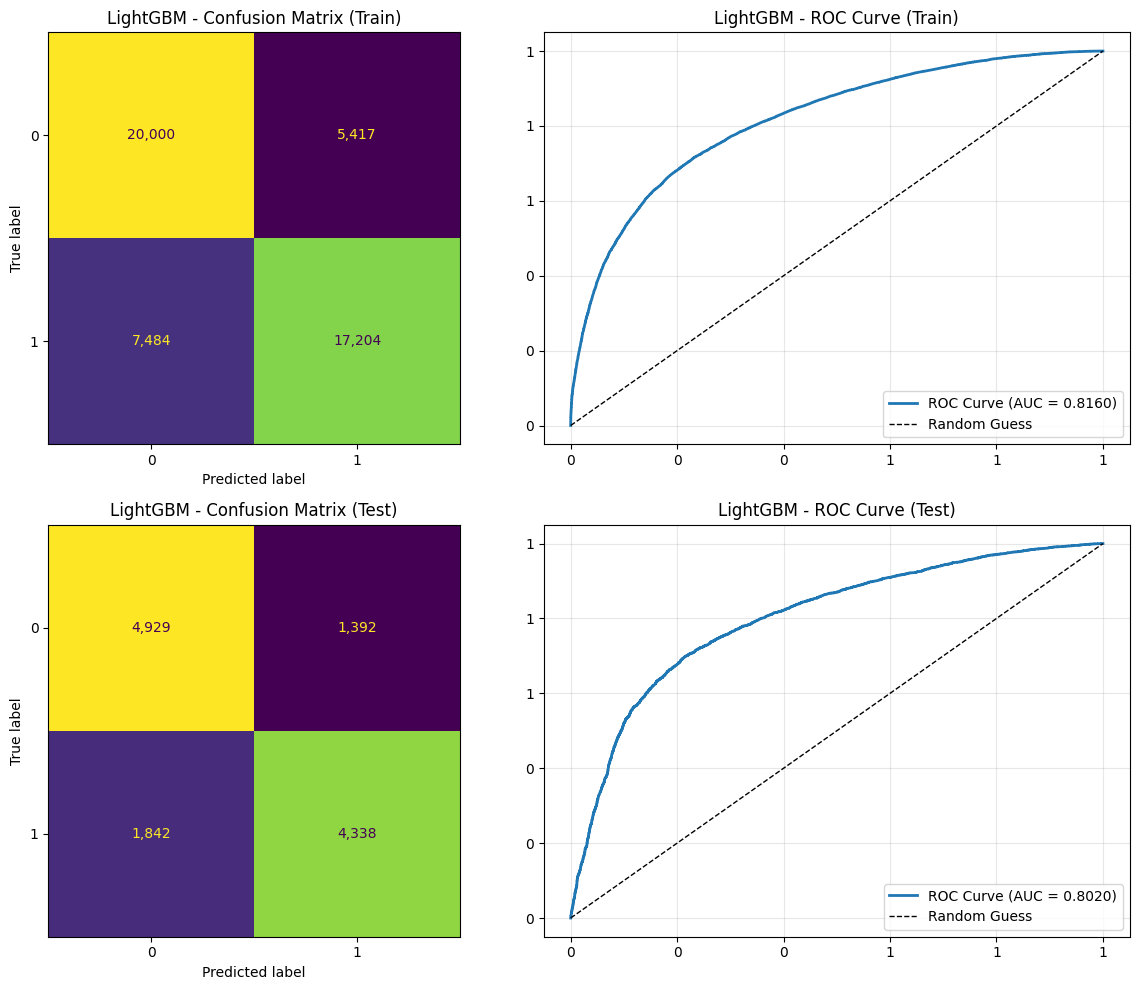

In [8]:
algorithm_name = 'LightGBM'
# ------------------------------
# Evaluasi Data Uji (Test)
# ------------------------------
y_pred_test = lgbm_model.predict(x_test_np)
accuracy_test = accuracy_score(y_test_np, y_pred_test)
report_test = classification_report(y_test_np, y_pred_test, digits=4)

test_pred_prob = lgbm_model.predict_proba(x_test_np)[:, 1]
auc_test = roc_auc_score(y_test_np, test_pred_prob)

print("Test Accuracy:", f"{accuracy_test:.6f}")
print("Test AUC:", f"{auc_test:.6f}")
print("\nTest Classification Report:\n", report_test)

# ------------------------------
# Evaluasi Data Latih (Train)
# ------------------------------
y_pred_train = lgbm_model.predict(x_train_np)
accuracy_train = accuracy_score(y_train_np, y_pred_train)
report_train = classification_report(y_train_np, y_pred_train, digits=4)

train_pred_prob = lgbm_model.predict_proba(x_train_np)[:, 1]
auc_train = roc_auc_score(y_train_np, train_pred_prob)

print("\nTrain Accuracy:", f"{accuracy_train:.6f}")
print("Train AUC:", f"{auc_train:.6f}")
print("\nTrain Classification Report:\n", report_train)

if accuracy_train > accuracy_test + 0.05 or auc_train > auc_test + 0.05:
    print("The model might be overfitting.")
else:
    print("No significant signs of overfitting.\n")

# ------------------------------
# Visualisasi Evaluasi (Train & Test)
# ------------------------------
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
display_labels = list(label_mapping.values()) if 'label_mapping' in globals() else None

cm_train = confusion_matrix(y_train_np, y_pred_train)
disp_train = ConfusionMatrixDisplay(confusion_matrix=cm_train, display_labels=display_labels)
disp_train.plot(ax=axes[0, 0], cmap='viridis', colorbar=False)
axes[0, 0].set_title(f"{algorithm_name} - Confusion Matrix (Train)")

fpr_train, tpr_train, _ = roc_curve(y_train_np, train_pred_prob)
axes[0, 1].plot(fpr_train, tpr_train, label=f"ROC Curve (AUC = {auc_train:.4f})", linewidth=2)
axes[0, 1].plot([0, 1], [0, 1], 'k--', label="Random Guess", linewidth=1)
axes[0, 1].set_title(f"{algorithm_name} - ROC Curve (Train)")
axes[0, 1].legend(loc="lower right")
axes[0, 1].grid(alpha=0.3)

cm_test = confusion_matrix(y_test_np, y_pred_test)
disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=display_labels)
disp_test.plot(ax=axes[1, 0], cmap='viridis', colorbar=False)
axes[1, 0].set_title(f"{algorithm_name} - Confusion Matrix (Test)")

fpr_test, tpr_test, _ = roc_curve(y_test_np, test_pred_prob)
axes[1, 1].plot(fpr_test, tpr_test, label=f"ROC Curve (AUC = {auc_test:.4f})", linewidth=2)
axes[1, 1].plot([0, 1], [0, 1], 'k--', label="Random Guess", linewidth=1)
axes[1, 1].set_title(f"{algorithm_name} - ROC Curve (Test)")
axes[1, 1].legend(loc="lower right")
axes[1, 1].grid(alpha=0.3)

for ax in axes.flat:
    ax.xaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
    ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))

for ax in [axes[0, 0], axes[1, 0]]:
    for text in ax.texts:
        try:
            val = float(text.get_text())
            text.set_text(f"{val:,.0f}")
        except ValueError:
            continue

plt.tight_layout()
plt.show()

In [9]:
# best_params = {
#     'iterations': 680, 
#     'learning_rate': 0.01040286438048717, 
#     'depth': 9, 
#     'l2_leaf_reg': 0.10424693387826892, 
#     'border_count': 220, 
#     'random_strength': 0.015513247584661348, 
#     'bagging_temperature': 0.2020691195100053, 
#     'random_seed': 7801,
#     'verbose': False
#     }

catb_model = CatBoostClassifier(verbose=False)
catb_results = evaluate_model(
    model= catb_model, 
    model_name="CatBoost", 
    framework="ml",
    x_train=x_train_np, 
    y_train=y_train, 
    x_test=x_test_np, 
    y_test=y_test
)

catb_results;



=== CatBoost ===

+-------+------------+-------------+
|       | Accuracy   |   AUC Score |
+=======+============+=============+
| Test  | 73.97%     |      0.8016 |
+-------+------------+-------------+
| Train | 75.17%     |      0.8283 |
+-------+------------+-------------+

Overfitting Check :
No significant signs of overfitting.



Test Accuracy: 0.739701
Test AUC: 0.801622

Test Classification Report:
               precision    recall  f1-score   support

           0     0.7252    0.7812    0.7522      6321
           1     0.7570    0.6972    0.7259      6180

    accuracy                         0.7397     12501
   macro avg     0.7411    0.7392    0.7390     12501
weighted avg     0.7409    0.7397    0.7392     12501


Train Accuracy: 0.751785
Train AUC: 0.828334

Train Classification Report:
               precision    recall  f1-score   support

           0     0.7348    0.7976    0.7649     25313
           1     0.7725    0.7048    0.7371     24688

    accuracy                         0.7518     50001
   macro avg     0.7537    0.7512    0.7510     50001
weighted avg     0.7534    0.7518    0.7512     50001

No significant signs of overfitting.



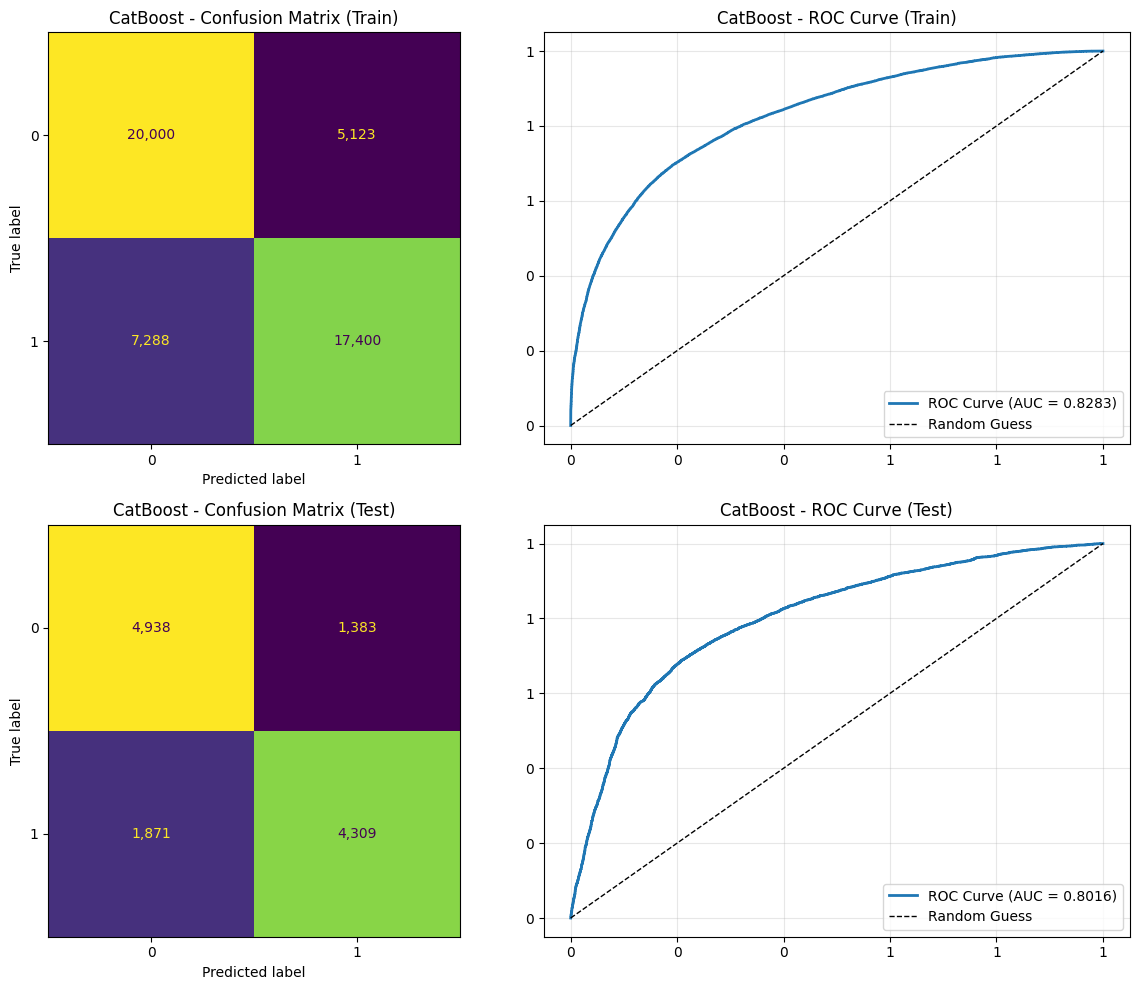

In [10]:
algorithm_name = 'CatBoost'
# ------------------------------
# Evaluasi Data Uji (Test)
# ------------------------------
y_pred_test = catb_model.predict(x_test_np)
accuracy_test = accuracy_score(y_test_np, y_pred_test)
report_test = classification_report(y_test_np, y_pred_test, digits=4)

test_pred_prob = catb_model.predict_proba(x_test_np)[:, 1]
auc_test = roc_auc_score(y_test_np, test_pred_prob)

print("Test Accuracy:", f"{accuracy_test:.6f}")
print("Test AUC:", f"{auc_test:.6f}")
print("\nTest Classification Report:\n", report_test)

# ------------------------------
# Evaluasi Data Latih (Train)
# ------------------------------
y_pred_train = catb_model.predict(x_train_np)
accuracy_train = accuracy_score(y_train_np, y_pred_train)
report_train = classification_report(y_train_np, y_pred_train, digits=4)

train_pred_prob = catb_model.predict_proba(x_train_np)[:, 1]
auc_train = roc_auc_score(y_train_np, train_pred_prob)

print("\nTrain Accuracy:", f"{accuracy_train:.6f}")
print("Train AUC:", f"{auc_train:.6f}")
print("\nTrain Classification Report:\n", report_train)

if accuracy_train > accuracy_test + 0.05 or auc_train > auc_test + 0.05:
    print("The model might be overfitting.")
else:
    print("No significant signs of overfitting.\n")

# ------------------------------
# Visualisasi Evaluasi (Train & Test)
# ------------------------------
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
display_labels = list(label_mapping.values()) if 'label_mapping' in globals() else None

cm_train = confusion_matrix(y_train_np, y_pred_train)
disp_train = ConfusionMatrixDisplay(confusion_matrix=cm_train, display_labels=display_labels)
disp_train.plot(ax=axes[0, 0], cmap='viridis', colorbar=False)
axes[0, 0].set_title(f"{algorithm_name} - Confusion Matrix (Train)")

fpr_train, tpr_train, _ = roc_curve(y_train_np, train_pred_prob)
axes[0, 1].plot(fpr_train, tpr_train, label=f"ROC Curve (AUC = {auc_train:.4f})", linewidth=2)
axes[0, 1].plot([0, 1], [0, 1], 'k--', label="Random Guess", linewidth=1)
axes[0, 1].set_title(f"{algorithm_name} - ROC Curve (Train)")
axes[0, 1].legend(loc="lower right")
axes[0, 1].grid(alpha=0.3)

cm_test = confusion_matrix(y_test_np, y_pred_test)
disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=display_labels)
disp_test.plot(ax=axes[1, 0], cmap='viridis', colorbar=False)
axes[1, 0].set_title(f"{algorithm_name} - Confusion Matrix (Test)")

fpr_test, tpr_test, _ = roc_curve(y_test_np, test_pred_prob)
axes[1, 1].plot(fpr_test, tpr_test, label=f"ROC Curve (AUC = {auc_test:.4f})", linewidth=2)
axes[1, 1].plot([0, 1], [0, 1], 'k--', label="Random Guess", linewidth=1)
axes[1, 1].set_title(f"{algorithm_name} - ROC Curve (Test)")
axes[1, 1].legend(loc="lower right")
axes[1, 1].grid(alpha=0.3)

for ax in axes.flat:
    ax.xaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
    ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))

for ax in [axes[0, 0], axes[1, 0]]:
    for text in ax.texts:
        try:
            val = float(text.get_text())
            text.set_text(f"{val:,.0f}")
        except ValueError:
            continue

plt.tight_layout()
plt.show()

In [11]:
# best_params = {
#     'max_iter': 409, 
#     'learning_rate': 0.01947652219796748, 
#     'max_leaf_nodes': 36, 
#     'min_samples_leaf': 28, 
#     'l2_regularization': 4.313378648780895e-06, 
#     'random_state': 8404
#             }

hgrb_model =  HistGradientBoostingClassifier(random_state=42)
hgrb_results = evaluate_model(
    model= hgrb_model, 
    model_name="Hist Gradient Boosting", 
    framework="ml",
    x_train=x_train_np, 
    y_train=y_train, 
    x_test=x_test_np, 
    y_test=y_test
)

hgrb_results;


=== Hist Gradient Boosting ===

+-------+------------+-------------+
|       | Accuracy   |   AUC Score |
+=======+============+=============+
| Test  | 73.88%     |      0.8016 |
+-------+------------+-------------+
| Train | 73.79%     |      0.8069 |
+-------+------------+-------------+

Overfitting Check :
No significant signs of overfitting.



Test Accuracy: 0.738821
Test AUC: 0.801585

Test Classification Report:
               precision    recall  f1-score   support

           0     0.7278    0.7723    0.7494      6321
           1     0.7516    0.7045    0.7273      6180

    accuracy                         0.7388     12501
   macro avg     0.7397    0.7384    0.7384     12501
weighted avg     0.7396    0.7388    0.7385     12501


Train Accuracy: 0.737945
Train AUC: 0.806854

Train Classification Report:
               precision    recall  f1-score   support

           0     0.7252    0.7767    0.7501     25313
           1     0.7531    0.6982    0.7246     24688

    accuracy                         0.7379     50001
   macro avg     0.7391    0.7375    0.7373     50001
weighted avg     0.7389    0.7379    0.7375     50001

No significant signs of overfitting.



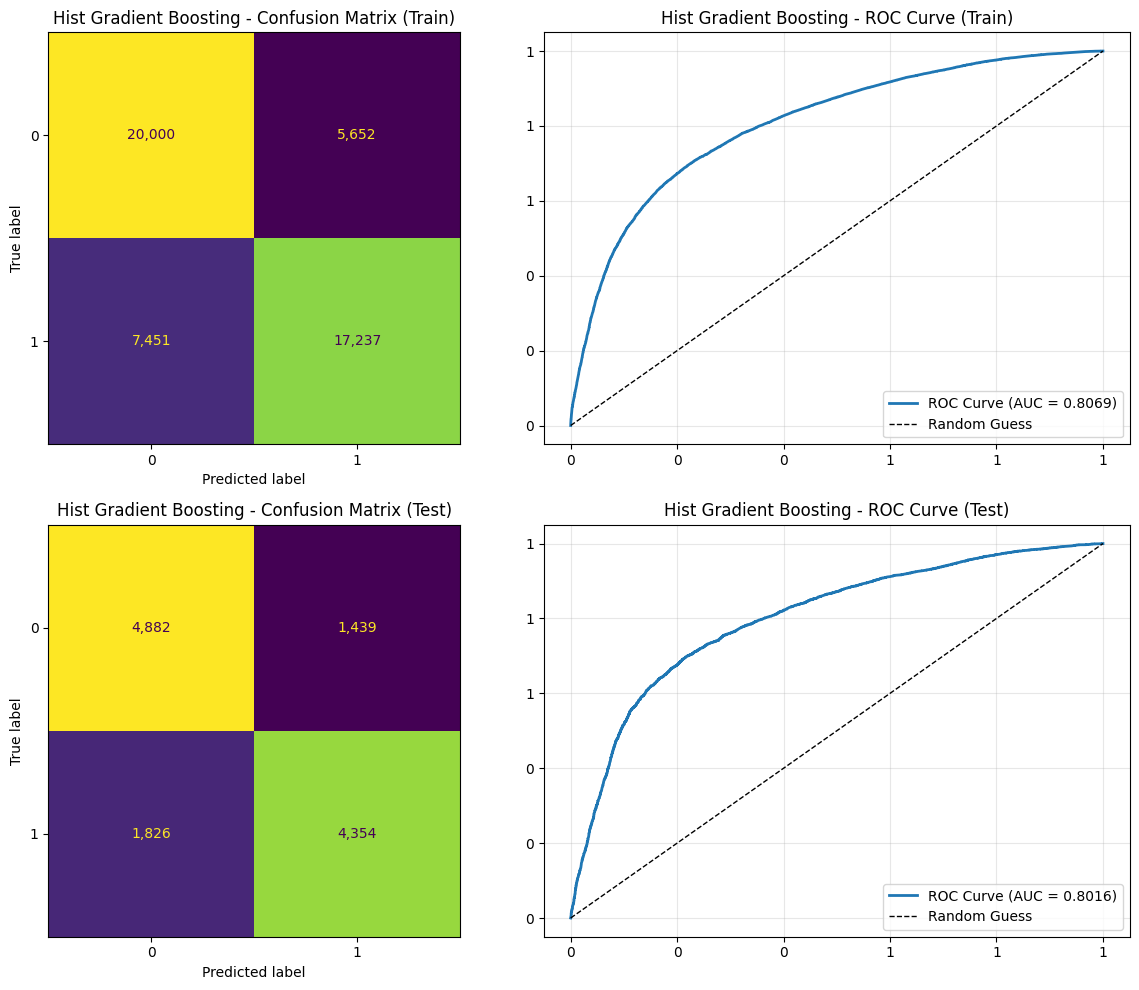

In [12]:
algorithm_name = 'Hist Gradient Boosting'
# ------------------------------
# Evaluasi Data Uji (Test)
# ------------------------------
y_pred_test = hgrb_model.predict(x_test_np)
accuracy_test = accuracy_score(y_test_np, y_pred_test)
report_test = classification_report(y_test_np, y_pred_test, digits=4)

test_pred_prob = hgrb_model.predict_proba(x_test_np)[:, 1]
auc_test = roc_auc_score(y_test_np, test_pred_prob)

print("Test Accuracy:", f"{accuracy_test:.6f}")
print("Test AUC:", f"{auc_test:.6f}")
print("\nTest Classification Report:\n", report_test)

# ------------------------------
# Evaluasi Data Latih (Train)
# ------------------------------
y_pred_train = hgrb_model.predict(x_train_np)
accuracy_train = accuracy_score(y_train_np, y_pred_train)
report_train = classification_report(y_train_np, y_pred_train, digits=4)

train_pred_prob = hgrb_model.predict_proba(x_train_np)[:, 1]
auc_train = roc_auc_score(y_train_np, train_pred_prob)

print("\nTrain Accuracy:", f"{accuracy_train:.6f}")
print("Train AUC:", f"{auc_train:.6f}")
print("\nTrain Classification Report:\n", report_train)

if accuracy_train > accuracy_test + 0.05 or auc_train > auc_test + 0.05:
    print("The model might be overfitting.")
else:
    print("No significant signs of overfitting.\n")

# ------------------------------
# Visualisasi Evaluasi (Train & Test)
# ------------------------------
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
display_labels = list(label_mapping.values()) if 'label_mapping' in globals() else None

cm_train = confusion_matrix(y_train_np, y_pred_train)
disp_train = ConfusionMatrixDisplay(confusion_matrix=cm_train, display_labels=display_labels)
disp_train.plot(ax=axes[0, 0], cmap='viridis', colorbar=False)
axes[0, 0].set_title(f"{algorithm_name} - Confusion Matrix (Train)")

fpr_train, tpr_train, _ = roc_curve(y_train_np, train_pred_prob)
axes[0, 1].plot(fpr_train, tpr_train, label=f"ROC Curve (AUC = {auc_train:.4f})", linewidth=2)
axes[0, 1].plot([0, 1], [0, 1], 'k--', label="Random Guess", linewidth=1)
axes[0, 1].set_title(f"{algorithm_name} - ROC Curve (Train)")
axes[0, 1].legend(loc="lower right")
axes[0, 1].grid(alpha=0.3)

cm_test = confusion_matrix(y_test_np, y_pred_test)
disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=display_labels)
disp_test.plot(ax=axes[1, 0], cmap='viridis', colorbar=False)
axes[1, 0].set_title(f"{algorithm_name} - Confusion Matrix (Test)")

fpr_test, tpr_test, _ = roc_curve(y_test_np, test_pred_prob)
axes[1, 1].plot(fpr_test, tpr_test, label=f"ROC Curve (AUC = {auc_test:.4f})", linewidth=2)
axes[1, 1].plot([0, 1], [0, 1], 'k--', label="Random Guess", linewidth=1)
axes[1, 1].set_title(f"{algorithm_name} - ROC Curve (Test)")
axes[1, 1].legend(loc="lower right")
axes[1, 1].grid(alpha=0.3)

for ax in axes.flat:
    ax.xaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
    ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))

for ax in [axes[0, 0], axes[1, 0]]:
    for text in ax.texts:
        try:
            val = float(text.get_text())
            text.set_text(f"{val:,.0f}")
        except ValueError:
            continue

plt.tight_layout()
plt.show()

In [13]:
# best_params = {'n_estimators': 478, 'learning_rate': 0.17278746878628695, 'random_state': 5660}

adb_model = AdaBoostClassifier()

adb_results = evaluate_model(
    model= adb_model, 
    model_name="AdaBoost", 
    framework="ml",
    x_train=x_train_np, 
    y_train=y_train, 
    x_test=x_test_np, 
    y_test=y_test
)

adb_results;

/home/qul/Developments/College/final_project/.venv_el/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(



=== AdaBoost ===

+-------+------------+-------------+
|       | Accuracy   |   AUC Score |
+=======+============+=============+
| Test  | 73.32%     |      0.7958 |
+-------+------------+-------------+
| Train | 72.42%     |      0.7902 |
+-------+------------+-------------+

Overfitting Check :
No significant signs of overfitting.



Test Accuracy: 0.733221
Test AUC: 0.795811

Test Classification Report:
               precision    recall  f1-score   support

           0     0.7060    0.8094    0.7542      6321
           1     0.7707    0.6553    0.7084      6180

    accuracy                         0.7332     12501
   macro avg     0.7384    0.7324    0.7313     12501
weighted avg     0.7380    0.7332    0.7315     12501


Train Accuracy: 0.724286
Train AUC: 0.790248

Train Classification Report:
               precision    recall  f1-score   support

           0     0.6969    0.8059    0.7475     25313
           1     0.7630    0.6406    0.6964     24688

    accuracy                         0.7243     50001
   macro avg     0.7299    0.7233    0.7219     50001
weighted avg     0.7295    0.7243    0.7223     50001

No significant signs of overfitting.



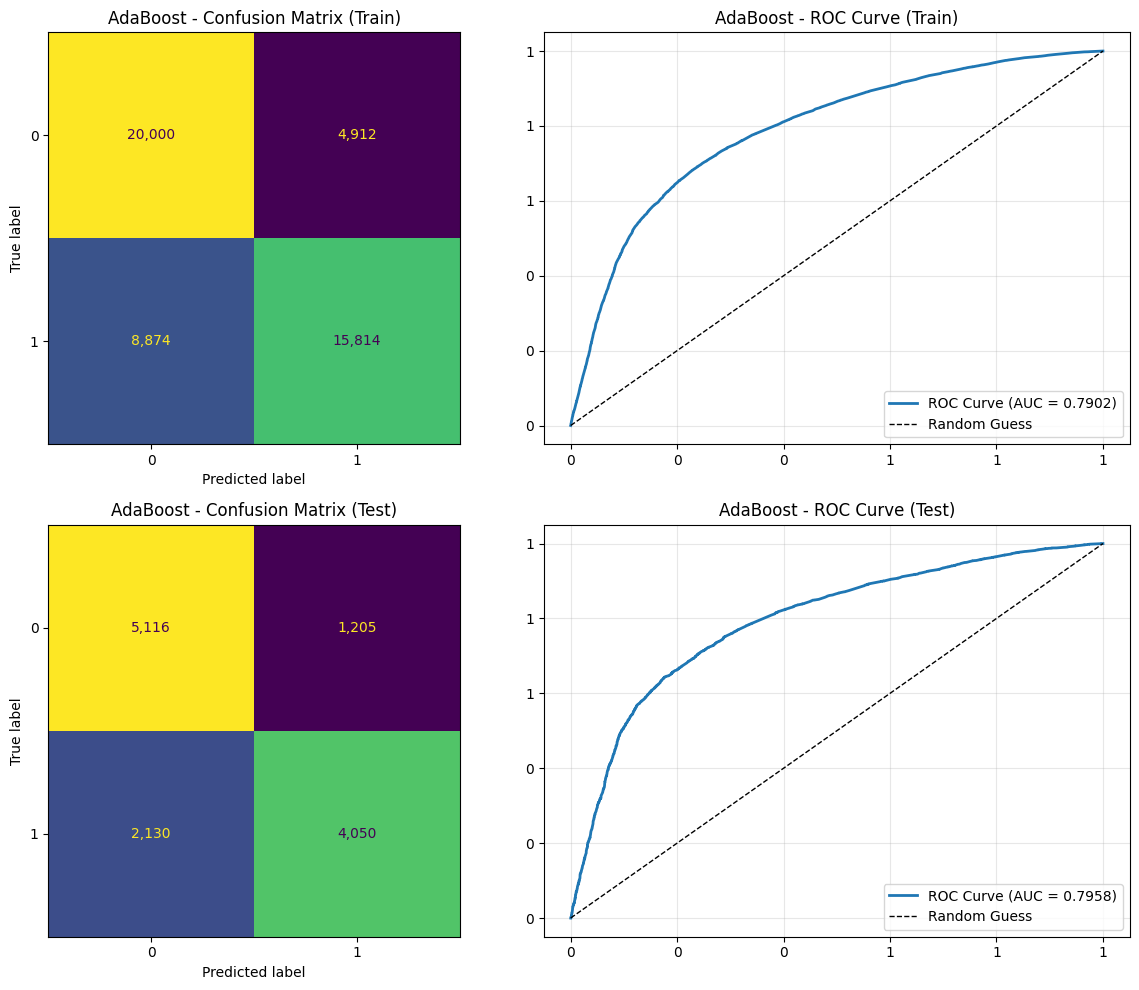

In [14]:
algorithm_name = 'AdaBoost'
# ------------------------------
# Evaluasi Data Uji (Test)
# ------------------------------
y_pred_test = adb_model.predict(x_test_np)
accuracy_test = accuracy_score(y_test_np, y_pred_test)
report_test = classification_report(y_test_np, y_pred_test, digits=4)

test_pred_prob = adb_model.predict_proba(x_test_np)[:, 1]
auc_test = roc_auc_score(y_test_np, test_pred_prob)

print("Test Accuracy:", f"{accuracy_test:.6f}")
print("Test AUC:", f"{auc_test:.6f}")
print("\nTest Classification Report:\n", report_test)

# ------------------------------
# Evaluasi Data Latih (Train)
# ------------------------------
y_pred_train = adb_model.predict(x_train_np)
accuracy_train = accuracy_score(y_train_np, y_pred_train)
report_train = classification_report(y_train_np, y_pred_train, digits=4)

train_pred_prob = adb_model.predict_proba(x_train_np)[:, 1]
auc_train = roc_auc_score(y_train_np, train_pred_prob)

print("\nTrain Accuracy:", f"{accuracy_train:.6f}")
print("Train AUC:", f"{auc_train:.6f}")
print("\nTrain Classification Report:\n", report_train)

if accuracy_train > accuracy_test + 0.05 or auc_train > auc_test + 0.05:
    print("The model might be overfitting.")
else:
    print("No significant signs of overfitting.\n")

# ------------------------------
# Visualisasi Evaluasi (Train & Test)
# ------------------------------
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
display_labels = list(label_mapping.values()) if 'label_mapping' in globals() else None

cm_train = confusion_matrix(y_train_np, y_pred_train)
disp_train = ConfusionMatrixDisplay(confusion_matrix=cm_train, display_labels=display_labels)
disp_train.plot(ax=axes[0, 0], cmap='viridis', colorbar=False)
axes[0, 0].set_title(f"{algorithm_name} - Confusion Matrix (Train)")

fpr_train, tpr_train, _ = roc_curve(y_train_np, train_pred_prob)
axes[0, 1].plot(fpr_train, tpr_train, label=f"ROC Curve (AUC = {auc_train:.4f})", linewidth=2)
axes[0, 1].plot([0, 1], [0, 1], 'k--', label="Random Guess", linewidth=1)
axes[0, 1].set_title(f"{algorithm_name} - ROC Curve (Train)")
axes[0, 1].legend(loc="lower right")
axes[0, 1].grid(alpha=0.3)

cm_test = confusion_matrix(y_test_np, y_pred_test)
disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=display_labels)
disp_test.plot(ax=axes[1, 0], cmap='viridis', colorbar=False)
axes[1, 0].set_title(f"{algorithm_name} - Confusion Matrix (Test)")

fpr_test, tpr_test, _ = roc_curve(y_test_np, test_pred_prob)
axes[1, 1].plot(fpr_test, tpr_test, label=f"ROC Curve (AUC = {auc_test:.4f})", linewidth=2)
axes[1, 1].plot([0, 1], [0, 1], 'k--', label="Random Guess", linewidth=1)
axes[1, 1].set_title(f"{algorithm_name} - ROC Curve (Test)")
axes[1, 1].legend(loc="lower right")
axes[1, 1].grid(alpha=0.3)

for ax in axes.flat:
    ax.xaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
    ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))

for ax in [axes[0, 0], axes[1, 0]]:
    for text in ax.texts:
        try:
            val = float(text.get_text())
            text.set_text(f"{val:,.0f}")
        except ValueError:
            continue

plt.tight_layout()
plt.show()

In [15]:
tabnet_model = TabNetClassifier(verbose=0)

tabnet_results = evaluate_model(
    model= tabnet_model, 
    model_name="TabNet", 
    framework="tabnet",
    x_train=x_train_np, 
    y_train=y_train, 
    x_test=x_test_np, 
    y_test=y_test
)

tabnet_results;

/home/qul/Developments/College/final_project/.venv_el/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)
/home/qul/Developments/College/final_project/.venv_el/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:285: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  return collate([torch.as_tensor(b) for b in batch], collate_fn_map=collate_fn_map)



=== TabNet ===

+-------+------------+-------------+
|       | Accuracy   |   AUC Score |
+=======+============+=============+
| Test  | 73.49%     |      0.7998 |
+-------+------------+-------------+
| Train | 72.94%     |      0.7977 |
+-------+------------+-------------+

Overfitting Check :
No significant signs of overfitting.



Test Accuracy: 0.734981
Test AUC: 0.799753

Test Classification Report:
               precision    recall  f1-score   support

           0     0.7332    0.7481    0.7406      6321
           1     0.7369    0.7215    0.7291      6180

    accuracy                         0.7350     12501
   macro avg     0.7350    0.7348    0.7349     12501
weighted avg     0.7350    0.7350    0.7349     12501


Train Accuracy: 0.729445
Train AUC: 0.797661

Train Classification Report:
               precision    recall  f1-score   support

           0     0.7283    0.7427    0.7354     25313
           1     0.7307    0.7159    0.7232     24688

    accuracy                         0.7294     50001
   macro avg     0.7295    0.7293    0.7293     50001
weighted avg     0.7295    0.7294    0.7294     50001

No significant signs of overfitting.



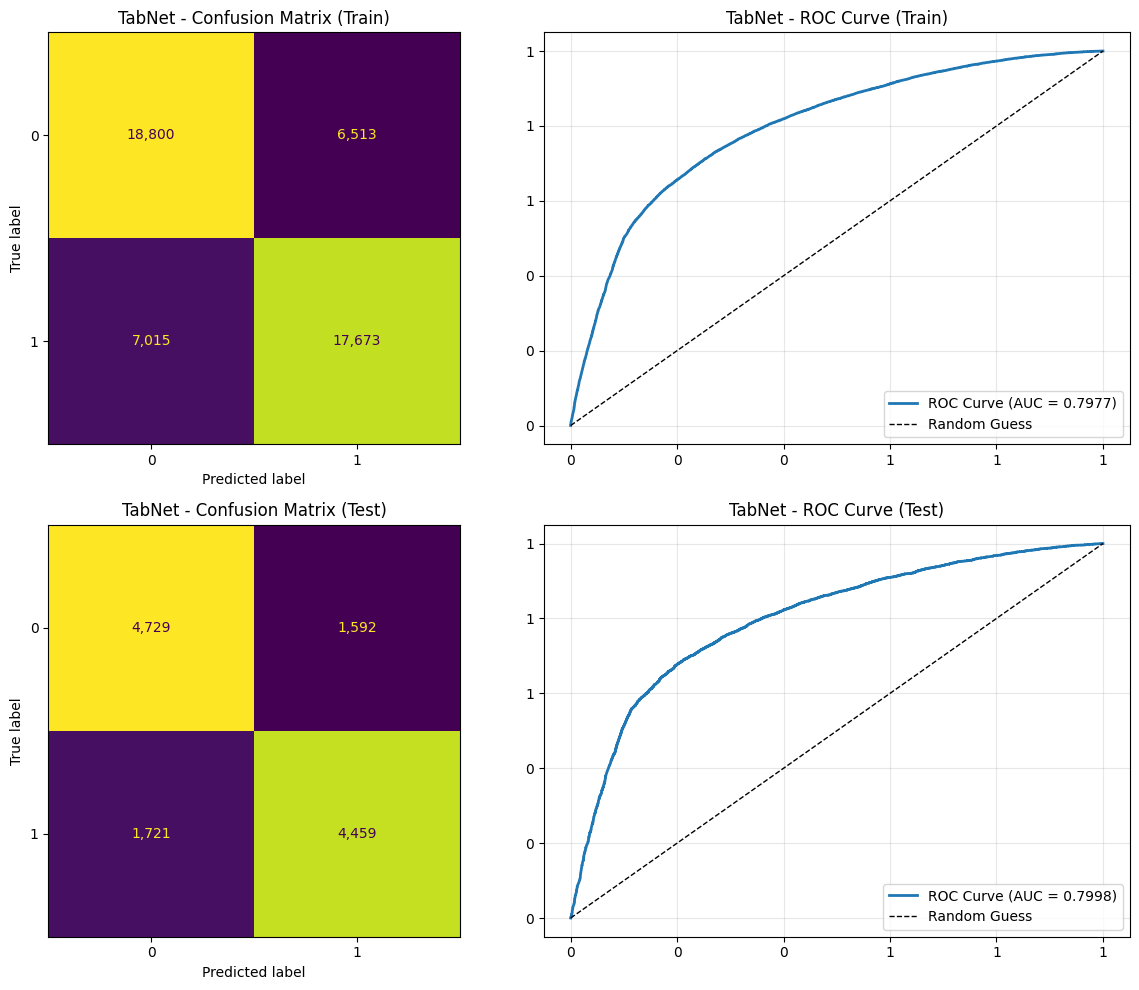

In [16]:
algorithm_name = 'TabNet'
# ------------------------------
# Evaluasi Data Uji (Test)
# ------------------------------
y_pred_test = tabnet_model.predict(x_test_np)
accuracy_test = accuracy_score(y_test_np, y_pred_test)
report_test = classification_report(y_test_np, y_pred_test, digits=4)

test_pred_prob = tabnet_model.predict_proba(x_test_np)[:, 1]
auc_test = roc_auc_score(y_test_np, test_pred_prob)

print("Test Accuracy:", f"{accuracy_test:.6f}")
print("Test AUC:", f"{auc_test:.6f}")
print("\nTest Classification Report:\n", report_test)

# ------------------------------
# Evaluasi Data Latih (Train)
# ------------------------------
y_pred_train = tabnet_model.predict(x_train_np)
accuracy_train = accuracy_score(y_train_np, y_pred_train)
report_train = classification_report(y_train_np, y_pred_train, digits=4)

train_pred_prob = tabnet_model.predict_proba(x_train_np)[:, 1]
auc_train = roc_auc_score(y_train_np, train_pred_prob)

print("\nTrain Accuracy:", f"{accuracy_train:.6f}")
print("Train AUC:", f"{auc_train:.6f}")
print("\nTrain Classification Report:\n", report_train)

if accuracy_train > accuracy_test + 0.05 or auc_train > auc_test + 0.05:
    print("The model might be overfitting.")
else:
    print("No significant signs of overfitting.\n")

# ------------------------------
# Visualisasi Evaluasi (Train & Test)
# ------------------------------
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
display_labels = list(label_mapping.values()) if 'label_mapping' in globals() else None

cm_train = confusion_matrix(y_train_np, y_pred_train)
disp_train = ConfusionMatrixDisplay(confusion_matrix=cm_train, display_labels=display_labels)
disp_train.plot(ax=axes[0, 0], cmap='viridis', colorbar=False)
axes[0, 0].set_title(f"{algorithm_name} - Confusion Matrix (Train)")

fpr_train, tpr_train, _ = roc_curve(y_train_np, train_pred_prob)
axes[0, 1].plot(fpr_train, tpr_train, label=f"ROC Curve (AUC = {auc_train:.4f})", linewidth=2)
axes[0, 1].plot([0, 1], [0, 1], 'k--', label="Random Guess", linewidth=1)
axes[0, 1].set_title(f"{algorithm_name} - ROC Curve (Train)")
axes[0, 1].legend(loc="lower right")
axes[0, 1].grid(alpha=0.3)

cm_test = confusion_matrix(y_test_np, y_pred_test)
disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=display_labels)
disp_test.plot(ax=axes[1, 0], cmap='viridis', colorbar=False)
axes[1, 0].set_title(f"{algorithm_name} - Confusion Matrix (Test)")

fpr_test, tpr_test, _ = roc_curve(y_test_np, test_pred_prob)
axes[1, 1].plot(fpr_test, tpr_test, label=f"ROC Curve (AUC = {auc_test:.4f})", linewidth=2)
axes[1, 1].plot([0, 1], [0, 1], 'k--', label="Random Guess", linewidth=1)
axes[1, 1].set_title(f"{algorithm_name} - ROC Curve (Test)")
axes[1, 1].legend(loc="lower right")
axes[1, 1].grid(alpha=0.3)

for ax in axes.flat:
    ax.xaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
    ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))

for ax in [axes[0, 0], axes[1, 0]]:
    for text in ax.texts:
        try:
            val = float(text.get_text())
            text.set_text(f"{val:,.0f}")
        except ValueError:
            continue

plt.tight_layout()
plt.show()

In [17]:
continuous_indices = list(range(len(numerical_features)))  
categorical_indices = list(range(len(numerical_features), len(transformed_feature_names)))  

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [18]:
tabtf_model = TabTransformer(
    categories = (3, 3, 2, 2, 2, 2), 
    num_continuous = len(continuous_indices),
    dim = 32,
    dim_out = 1,
    depth = 6,
    heads = 8,
    attn_dropout = 0.1,
    ff_dropout = 0.1,
    mlp_hidden_mults = (4, 2),
    mlp_act = nn.ReLU(),
    continuous_mean_std = None
).to(device)

tabtf_results = evaluate_model(
    model=tabtf_model, 
    model_name="TabTransformer", 
    framework="tab transformer",
    x_train=x_train_np, 
    y_train=y_train_np, 
    x_test=x_test_np, 
    y_test=y_test_np
)
tabtf_results;

Epoch 1/10, Training Loss: 0.6253
Epoch 2/10, Training Loss: 0.5747
Epoch 3/10, Training Loss: 0.5648
Epoch 4/10, Training Loss: 0.5628
Epoch 5/10, Training Loss: 0.5611
Epoch 6/10, Training Loss: 0.5604
Epoch 7/10, Training Loss: 0.5586
Epoch 8/10, Training Loss: 0.5583
Epoch 9/10, Training Loss: 0.5567
Epoch 10/10, Training Loss: 0.5558

=== TabTransformer ===

+-------+------------+-------------+
|       | Accuracy   |   AUC Score |
+=======+============+=============+
| Test  | 73.47%     |      0.7975 |
+-------+------------+-------------+
| Train | 72.93%     |      0.794  |
+-------+------------+-------------+

Overfitting Check :
No significant signs of overfitting.



Test Accuracy: 0.734741
Test AUC: 0.797534

Test Classification Report:
               precision    recall  f1-score   support

           0     0.7231    0.7704    0.7460      6321
           1     0.7484    0.6982    0.7224      6180

    accuracy                         0.7347     12501
   macro avg     0.7357    0.7343    0.7342     12501
weighted avg     0.7356    0.7347    0.7344     12501


Train Accuracy: 0.729345
Train AUC: 0.794031

Train Classification Report:
               precision    recall  f1-score   support

           0     0.7170    0.7688    0.7420     25313
           1     0.7440    0.6889    0.7154     24688

    accuracy                         0.7293     50001
   macro avg     0.7305    0.7288    0.7287     50001
weighted avg     0.7303    0.7293    0.7289     50001

No significant signs of overfitting.



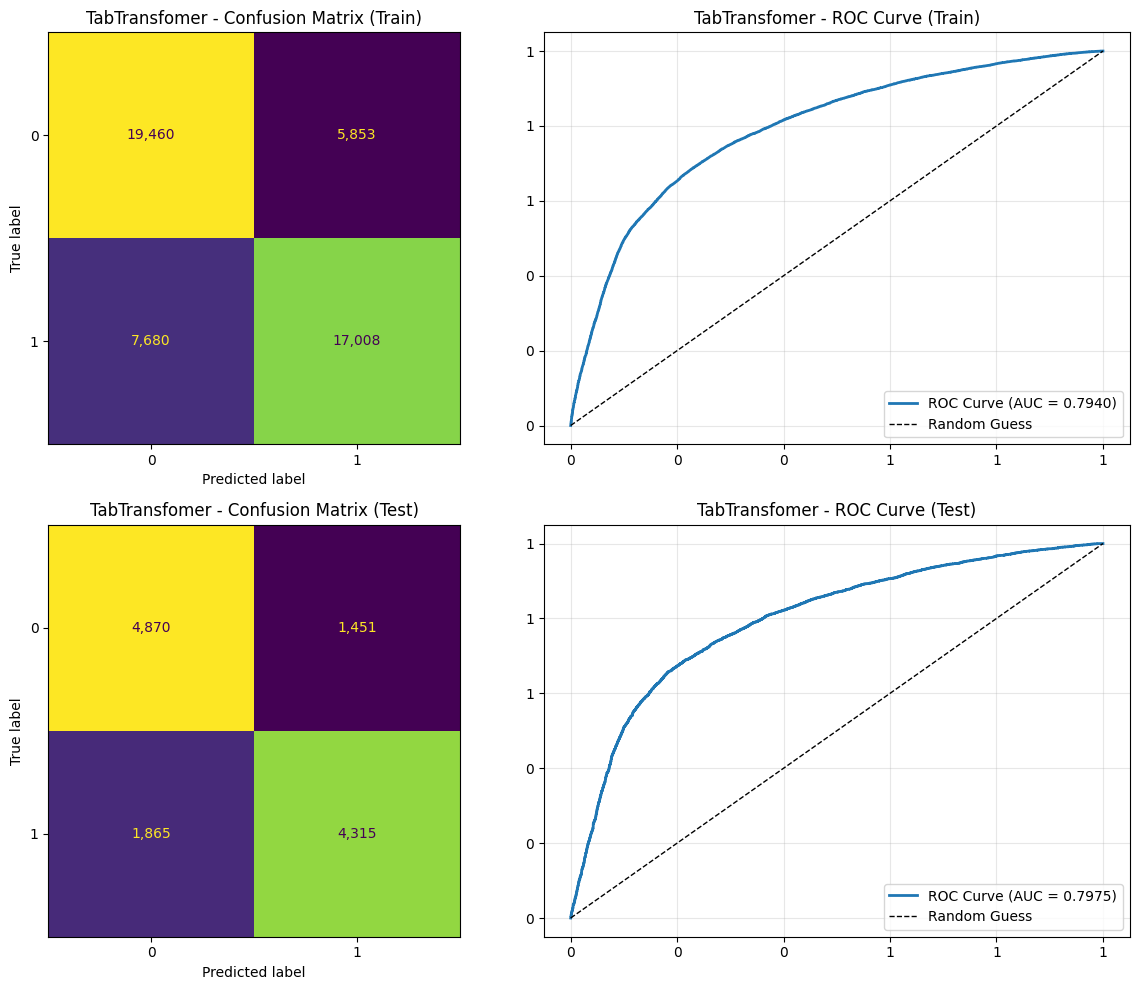

In [19]:
algorithm_name = 'TabTransfomer'

all_indices = np.arange(x_test_np.shape[1])
categorical_indices = np.setdiff1d(all_indices, continuous_indices)

x_cat_test = torch.from_numpy(x_test_np[:, categorical_indices]).long().to(device)
x_cont_test = torch.from_numpy(x_test_np[:, continuous_indices]).float().to(device)

x_cat_train = torch.from_numpy(x_train_np[:, categorical_indices]).long().to(device)
x_cont_train = torch.from_numpy(x_train_np[:, continuous_indices]).float().to(device)

# Pastikan model dalam mode evaluasi
tabtf_model.eval()

# ------------------------------
# Evaluasi Data Uji (Test)
# ------------------------------
with torch.no_grad():
    test_outputs = tabtf_model(x_cat_test, x_cont_test).squeeze(-1)
    test_pred_prob = torch.sigmoid(test_outputs).cpu().numpy()
y_pred_test = (test_pred_prob >= 0.5).astype(int)

accuracy_test = accuracy_score(y_test_np, y_pred_test)
report_test = classification_report(y_test_np, y_pred_test, digits=4)
auc_test = roc_auc_score(y_test_np, test_pred_prob)

print("Test Accuracy:", f"{accuracy_test:.6f}")
print("Test AUC:", f"{auc_test:.6f}")
print("\nTest Classification Report:\n", report_test)

# ------------------------------
# Evaluasi Data Latih (Train)
# ------------------------------
with torch.no_grad():
    train_outputs = tabtf_model(x_cat_train, x_cont_train).squeeze(-1)
    train_pred_prob = torch.sigmoid(train_outputs).cpu().numpy()
y_pred_train = (train_pred_prob >= 0.5).astype(int)

accuracy_train = accuracy_score(y_train_np, y_pred_train)
report_train = classification_report(y_train_np, y_pred_train, digits=4)
auc_train = roc_auc_score(y_train_np, train_pred_prob)

print("\nTrain Accuracy:", f"{accuracy_train:.6f}")
print("Train AUC:", f"{auc_train:.6f}")
print("\nTrain Classification Report:\n", report_train)

if accuracy_train > accuracy_test + 0.05 or auc_train > auc_test + 0.05:
    print("The model might be overfitting.")
else:
    print("No significant signs of overfitting.\n")

# ------------------------------
# Visualisasi Evaluasi (Train & Test)
# ------------------------------
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
display_labels = list(label_mapping.values()) if 'label_mapping' in globals() else None

# Confusion Matrix (Train)
cm_train = confusion_matrix(y_train_np, y_pred_train)
disp_train = ConfusionMatrixDisplay(confusion_matrix=cm_train, display_labels=display_labels)
disp_train.plot(ax=axes[0, 0], cmap='viridis', colorbar=False)
axes[0, 0].set_title(f"{algorithm_name} - Confusion Matrix (Train)")

# ROC Curve (Train)
fpr_train, tpr_train, _ = roc_curve(y_train_np, train_pred_prob)
axes[0, 1].plot(fpr_train, tpr_train, label=f"ROC Curve (AUC = {auc_train:.4f})", linewidth=2)
axes[0, 1].plot([0, 1], [0, 1], 'k--', label="Random Guess", linewidth=1)
axes[0, 1].set_title(f"{algorithm_name} - ROC Curve (Train)")
axes[0, 1].legend(loc="lower right")
axes[0, 1].grid(alpha=0.3)

# Confusion Matrix (Test)
cm_test = confusion_matrix(y_test_np, y_pred_test)
disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=display_labels)
disp_test.plot(ax=axes[1, 0], cmap='viridis', colorbar=False)
axes[1, 0].set_title(f"{algorithm_name} - Confusion Matrix (Test)")

# ROC Curve (Test)
fpr_test, tpr_test, _ = roc_curve(y_test_np, test_pred_prob)
axes[1, 1].plot(fpr_test, tpr_test, label=f"ROC Curve (AUC = {auc_test:.4f})", linewidth=2)
axes[1, 1].plot([0, 1], [0, 1], 'k--', label="Random Guess", linewidth=1)
axes[1, 1].set_title(f"{algorithm_name} - ROC Curve (Test)")
axes[1, 1].legend(loc="lower right")
axes[1, 1].grid(alpha=0.3)

for ax in axes.flat:
    ax.xaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
    ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))

for ax in [axes[0, 0], axes[1, 0]]:
    for text in ax.texts:
        try:
            val = float(text.get_text())
            text.set_text(f"{val:,.0f}")
        except ValueError:
            continue

plt.tight_layout()
plt.show()

In [20]:
wrapped_tabtf = PyTorchClassifier(
    model=tabtf_model,
    epochs=10,
    lr=1e-3,
    batch_size=32,
    continuous_indices=list(range(len(numerical_features))),
    categorical_indices=list(range(len(numerical_features), len(transformed_feature_names)))
)


In [21]:
fttf_model = FTTransformer(
    categories = (3, 3, 2, 2, 2, 2), 
    num_continuous = len(continuous_indices),
    dim = 32,
    dim_out = 1,
    depth = 6,
    heads = 8,
    attn_dropout = 0.1,
    ff_dropout = 0.1
).to(device)

fttf_results = evaluate_model(
    model=fttf_model, 
    model_name="TabTransformer", 
    framework="tab transformer",
    x_train=x_train_np, 
    y_train=y_train_np, 
    x_test=x_test_np, 
    y_test=y_test_np
)
fttf_results;

Epoch 1/10, Training Loss: 0.5602
Epoch 2/10, Training Loss: 0.5539
Epoch 3/10, Training Loss: 0.5528
Epoch 4/10, Training Loss: 0.5516
Epoch 5/10, Training Loss: 0.5516
Epoch 6/10, Training Loss: 0.5506
Epoch 7/10, Training Loss: 0.5500
Epoch 8/10, Training Loss: 0.5496
Epoch 9/10, Training Loss: 0.5494
Epoch 10/10, Training Loss: 0.5488

=== TabTransformer ===

+-------+------------+-------------+
|       | Accuracy   |   AUC Score |
+=======+============+=============+
| Test  | 73.52%     |      0.8008 |
+-------+------------+-------------+
| Train | 72.76%     |      0.7972 |
+-------+------------+-------------+

Overfitting Check :
No significant signs of overfitting.



Test Accuracy: 0.735221
Test AUC: 0.800781

Test Classification Report:
               precision    recall  f1-score   support

           0     0.7399    0.7345    0.7372      6321
           1     0.7305    0.7359    0.7332      6180

    accuracy                         0.7352     12501
   macro avg     0.7352    0.7352    0.7352     12501
weighted avg     0.7353    0.7352    0.7352     12501


Train Accuracy: 0.727685
Train AUC: 0.797159

Train Classification Report:
               precision    recall  f1-score   support

           0     0.7316    0.7299    0.7307     25313
           1     0.7237    0.7254    0.7246     24688

    accuracy                         0.7277     50001
   macro avg     0.7276    0.7277    0.7277     50001
weighted avg     0.7277    0.7277    0.7277     50001

No significant signs of overfitting.



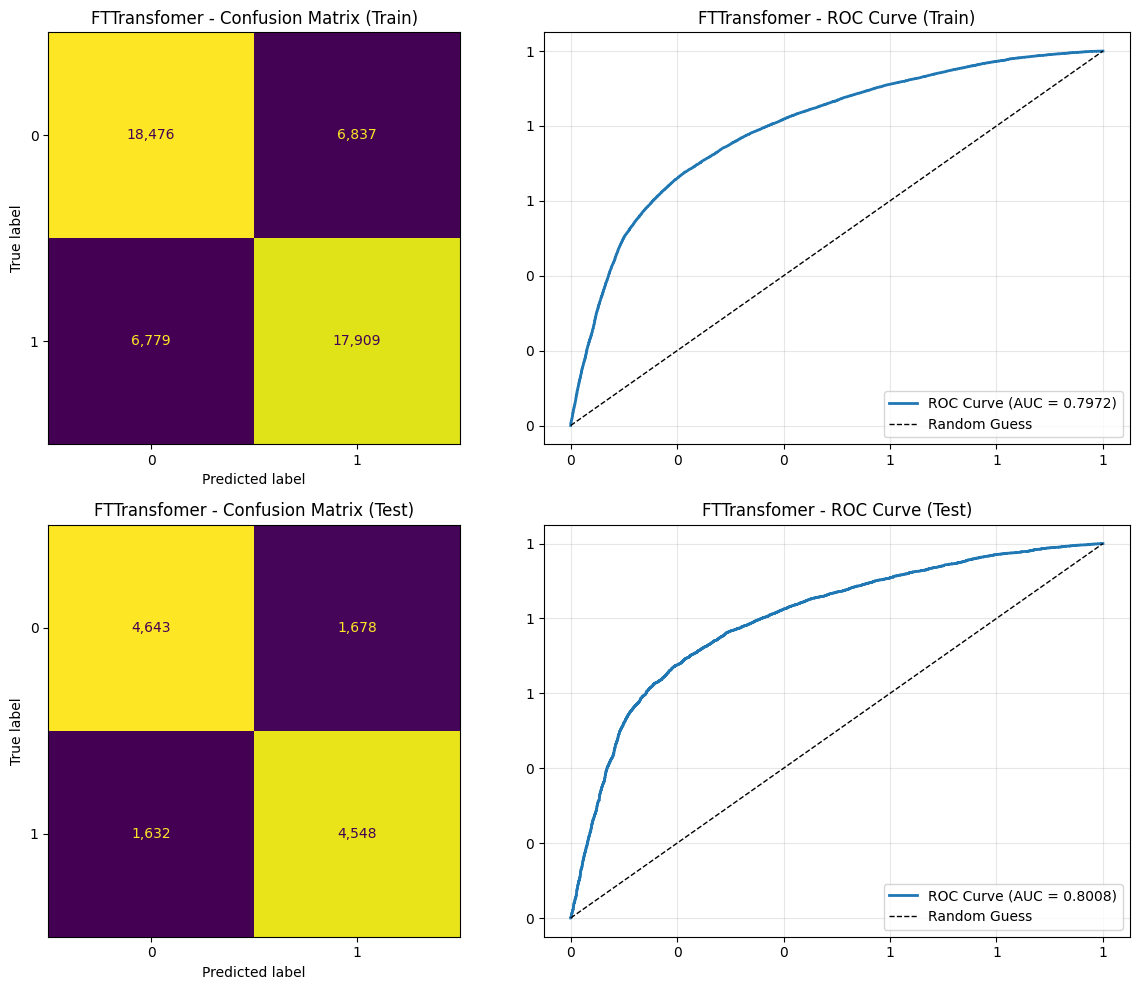

In [22]:
algorithm_name = 'FTTransfomer'

all_indices = np.arange(x_test_np.shape[1])
categorical_indices = np.setdiff1d(all_indices, continuous_indices)

x_cat_test = torch.from_numpy(x_test_np[:, categorical_indices]).long().to(device)
x_cont_test = torch.from_numpy(x_test_np[:, continuous_indices]).float().to(device)

x_cat_train = torch.from_numpy(x_train_np[:, categorical_indices]).long().to(device)
x_cont_train = torch.from_numpy(x_train_np[:, continuous_indices]).float().to(device)

# Pastikan model dalam mode evaluasi
fttf_model.eval()

# ------------------------------
# Evaluasi Data Uji (Test)
# ------------------------------
with torch.no_grad():
    test_outputs = fttf_model(x_cat_test, x_cont_test).squeeze(-1)
    test_pred_prob = torch.sigmoid(test_outputs).cpu().numpy()
y_pred_test = (test_pred_prob >= 0.5).astype(int)

accuracy_test = accuracy_score(y_test_np, y_pred_test)
report_test = classification_report(y_test_np, y_pred_test, digits=4)
auc_test = roc_auc_score(y_test_np, test_pred_prob)

print("Test Accuracy:", f"{accuracy_test:.6f}")
print("Test AUC:", f"{auc_test:.6f}")
print("\nTest Classification Report:\n", report_test)

# ------------------------------
# Evaluasi Data Latih (Train)
# ------------------------------
with torch.no_grad():
    train_outputs = fttf_model(x_cat_train, x_cont_train).squeeze(-1)
    train_pred_prob = torch.sigmoid(train_outputs).cpu().numpy()
y_pred_train = (train_pred_prob >= 0.5).astype(int)

accuracy_train = accuracy_score(y_train_np, y_pred_train)
report_train = classification_report(y_train_np, y_pred_train, digits=4)
auc_train = roc_auc_score(y_train_np, train_pred_prob)

print("\nTrain Accuracy:", f"{accuracy_train:.6f}")
print("Train AUC:", f"{auc_train:.6f}")
print("\nTrain Classification Report:\n", report_train)

if accuracy_train > accuracy_test + 0.05 or auc_train > auc_test + 0.05:
    print("The model might be overfitting.")
else:
    print("No significant signs of overfitting.\n")

# ------------------------------
# Visualisasi Evaluasi (Train & Test)
# ------------------------------
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
display_labels = list(label_mapping.values()) if 'label_mapping' in globals() else None

# Confusion Matrix (Train)
cm_train = confusion_matrix(y_train_np, y_pred_train)
disp_train = ConfusionMatrixDisplay(confusion_matrix=cm_train, display_labels=display_labels)
disp_train.plot(ax=axes[0, 0], cmap='viridis', colorbar=False)
axes[0, 0].set_title(f"{algorithm_name} - Confusion Matrix (Train)")

# ROC Curve (Train)
fpr_train, tpr_train, _ = roc_curve(y_train_np, train_pred_prob)
axes[0, 1].plot(fpr_train, tpr_train, label=f"ROC Curve (AUC = {auc_train:.4f})", linewidth=2)
axes[0, 1].plot([0, 1], [0, 1], 'k--', label="Random Guess", linewidth=1)
axes[0, 1].set_title(f"{algorithm_name} - ROC Curve (Train)")
axes[0, 1].legend(loc="lower right")
axes[0, 1].grid(alpha=0.3)

# Confusion Matrix (Test)
cm_test = confusion_matrix(y_test_np, y_pred_test)
disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=display_labels)
disp_test.plot(ax=axes[1, 0], cmap='viridis', colorbar=False)
axes[1, 0].set_title(f"{algorithm_name} - Confusion Matrix (Test)")

# ROC Curve (Test)
fpr_test, tpr_test, _ = roc_curve(y_test_np, test_pred_prob)
axes[1, 1].plot(fpr_test, tpr_test, label=f"ROC Curve (AUC = {auc_test:.4f})", linewidth=2)
axes[1, 1].plot([0, 1], [0, 1], 'k--', label="Random Guess", linewidth=1)
axes[1, 1].set_title(f"{algorithm_name} - ROC Curve (Test)")
axes[1, 1].legend(loc="lower right")
axes[1, 1].grid(alpha=0.3)

for ax in axes.flat:
    ax.xaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
    ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))

for ax in [axes[0, 0], axes[1, 0]]:
    for text in ax.texts:
        try:
            val = float(text.get_text())
            text.set_text(f"{val:,.0f}")
        except ValueError:
            continue

plt.tight_layout()
plt.show()

In [23]:
wrapped_fttf = PyTorchClassifier(
    model=fttf_model,
    epochs=10,
    lr=1e-3,
    batch_size=32,
    continuous_indices=list(range(len(numerical_features))),
    categorical_indices=list(range(len(numerical_features), len(transformed_feature_names)))
)


In [24]:
base_models_ml = [
    ('lgbm', lgbm_model),
    ('cat', catb_model),
    ('hgrb', hgrb_model)
]

base_models_dl = [
    ('tabnet', tabnet_model),
    ('tabtf', wrapped_tabtf),
    ('fttf', wrapped_fttf)
]

base_models_el = [
    ('lgbm', lgbm_model),
    ('cat', catb_model),
    ('hgrb', hgrb_model),
    ('tabnet', tabnet_model),
    ('tabtf', wrapped_tabtf),
    ('fttf', wrapped_fttf)
]

In [25]:
meta_model = adb_model

In [26]:
stacking_model_ml = StackingClassifier(estimators=base_models_ml,
                                    final_estimator=meta_model,
                                    cv=5,
                                    passthrough=True)

stacking_model_dl = StackingClassifier(estimators=base_models_dl,
                                    final_estimator=meta_model,
                                    cv=5,
                                    passthrough=True)

stacking_model_el = StackingClassifier(estimators=base_models_el,
                                    final_estimator=meta_model,
                                    cv=5,
                                    passthrough=True)

In [27]:
stacking_model_ml.fit(x_train_np, y_train_np)

/home/qul/Developments/College/final_project/.venv_el/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


StackingClassifier(cv=5,
                   estimators=[('lgbm', LGBMClassifier(verbose=-1)),
                               ('cat',
                                <catboost.core.CatBoostClassifier object at 0x784e693499f0>),
                               ('hgrb',
                                HistGradientBoostingClassifier(random_state=42))],
                   final_estimator=AdaBoostClassifier(), passthrough=True)

Test Accuracy: 0.737381
Test AUC: 0.801141

Test Classification Report:
               precision    recall  f1-score   support

           0     0.7063    0.8228    0.7601      6321
           1     0.7820    0.6500    0.7099      6180

    accuracy                         0.7374     12501
   macro avg     0.7441    0.7364    0.7350     12501
weighted avg     0.7437    0.7374    0.7353     12501


Train Accuracy: 0.737665
Train AUC: 0.813405

Train Classification Report:
               precision    recall  f1-score   support

           0     0.7043    0.8304    0.7622     25313
           1     0.7870    0.6426    0.7075     24688

    accuracy                         0.7377     50001
   macro avg     0.7457    0.7365    0.7348     50001
weighted avg     0.7452    0.7377    0.7352     50001

No significant signs of overfitting.



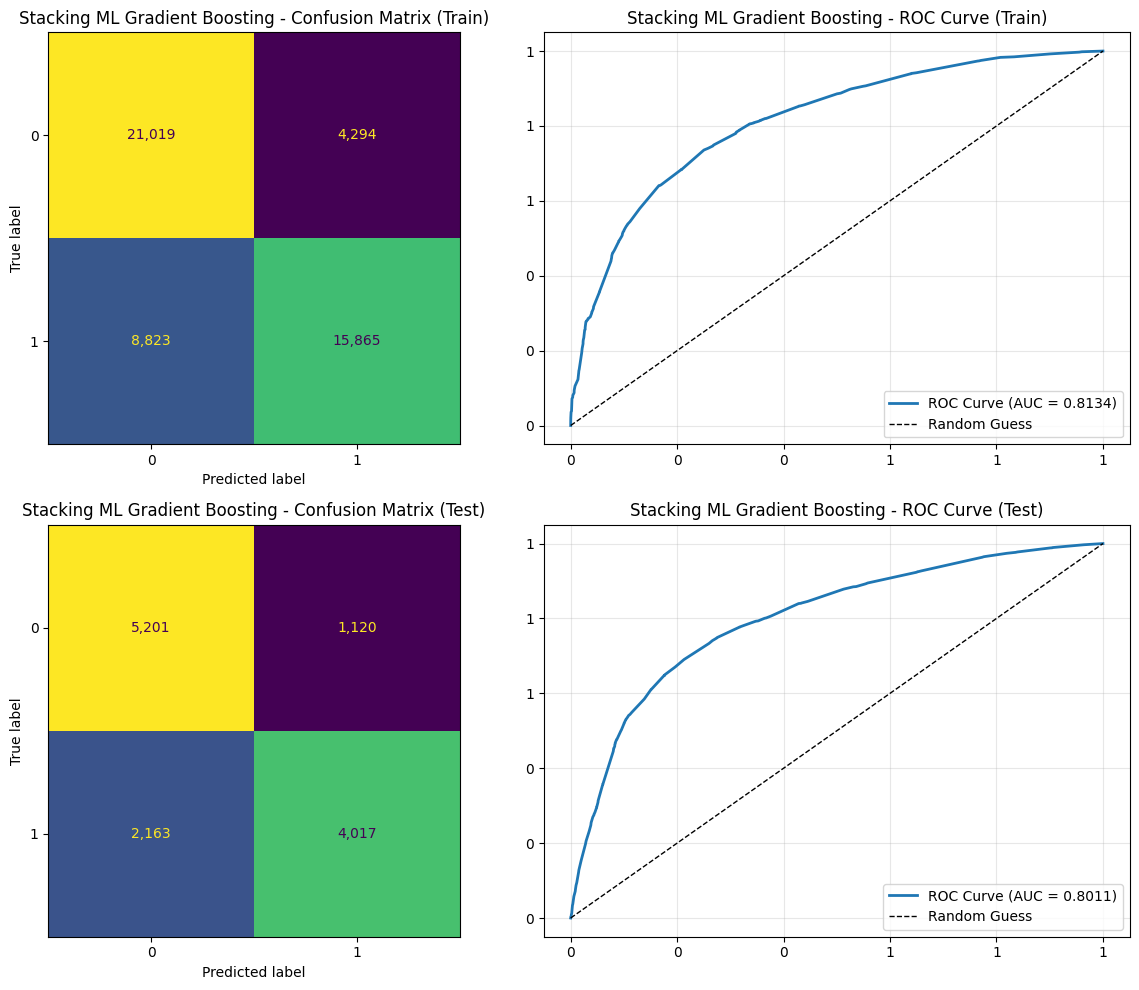

In [28]:
algorithm_name = 'Stacking ML Gradient Boosting'
# ------------------------------
# Evaluasi Data Uji (Test)
# ------------------------------
y_pred_test = stacking_model_ml.predict(x_test_np)
accuracy_test = accuracy_score(y_test_np, y_pred_test)
report_test = classification_report(y_test_np, y_pred_test, digits=4)

test_pred_prob = stacking_model_ml.predict_proba(x_test_np)[:, 1]
auc_test = roc_auc_score(y_test_np, test_pred_prob)

print("Test Accuracy:", f"{accuracy_test:.6f}")
print("Test AUC:", f"{auc_test:.6f}")
print("\nTest Classification Report:\n", report_test)

# ------------------------------
# Evaluasi Data Latih (Train)
# ------------------------------
y_pred_train = stacking_model_ml.predict(x_train_np)
accuracy_train = accuracy_score(y_train_np, y_pred_train)
report_train = classification_report(y_train_np, y_pred_train, digits=4)

train_pred_prob = stacking_model_ml.predict_proba(x_train_np)[:, 1]
auc_train = roc_auc_score(y_train_np, train_pred_prob)

print("\nTrain Accuracy:", f"{accuracy_train:.6f}")
print("Train AUC:", f"{auc_train:.6f}")
print("\nTrain Classification Report:\n", report_train)

if accuracy_train > accuracy_test + 0.05 or auc_train > auc_test + 0.05:
    print("The model might be overfitting.")
else:
    print("No significant signs of overfitting.\n")

# ------------------------------
# Visualisasi Evaluasi (Train & Test)
# ------------------------------
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
display_labels = list(label_mapping.values()) if 'label_mapping' in globals() else None

cm_train = confusion_matrix(y_train_np, y_pred_train)
disp_train = ConfusionMatrixDisplay(confusion_matrix=cm_train, display_labels=display_labels)
disp_train.plot(ax=axes[0, 0], cmap='viridis', colorbar=False)
axes[0, 0].set_title(f"{algorithm_name} - Confusion Matrix (Train)")

fpr_train, tpr_train, _ = roc_curve(y_train_np, train_pred_prob)
axes[0, 1].plot(fpr_train, tpr_train, label=f"ROC Curve (AUC = {auc_train:.4f})", linewidth=2)
axes[0, 1].plot([0, 1], [0, 1], 'k--', label="Random Guess", linewidth=1)
axes[0, 1].set_title(f"{algorithm_name} - ROC Curve (Train)")
axes[0, 1].legend(loc="lower right")
axes[0, 1].grid(alpha=0.3)

cm_test = confusion_matrix(y_test_np, y_pred_test)
disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=display_labels)
disp_test.plot(ax=axes[1, 0], cmap='viridis', colorbar=False)
axes[1, 0].set_title(f"{algorithm_name} - Confusion Matrix (Test)")

fpr_test, tpr_test, _ = roc_curve(y_test_np, test_pred_prob)
axes[1, 1].plot(fpr_test, tpr_test, label=f"ROC Curve (AUC = {auc_test:.4f})", linewidth=2)
axes[1, 1].plot([0, 1], [0, 1], 'k--', label="Random Guess", linewidth=1)
axes[1, 1].set_title(f"{algorithm_name} - ROC Curve (Test)")
axes[1, 1].legend(loc="lower right")
axes[1, 1].grid(alpha=0.3)

for ax in axes.flat:
    ax.xaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
    ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))

for ax in [axes[0, 0], axes[1, 0]]:
    for text in ax.texts:
        try:
            val = float(text.get_text())
            text.set_text(f"{val:,.0f}")
        except ValueError:
            continue

plt.tight_layout()
plt.show()

In [29]:
stacking_model_dl.fit(x_train_np, y_train_np)

/home/qul/Developments/College/final_project/.venv_el/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


[Wrapper] Epoch 1/10, Loss: 0.5557
[Wrapper] Epoch 2/10, Loss: 0.5549
[Wrapper] Epoch 3/10, Loss: 0.5541
[Wrapper] Epoch 4/10, Loss: 0.5544
[Wrapper] Epoch 5/10, Loss: 0.5536
[Wrapper] Epoch 6/10, Loss: 0.5528
[Wrapper] Epoch 7/10, Loss: 0.5518
[Wrapper] Epoch 8/10, Loss: 0.5524
[Wrapper] Epoch 9/10, Loss: 0.5515
[Wrapper] Epoch 10/10, Loss: 0.5501
[Wrapper] Epoch 1/10, Loss: 0.5481
[Wrapper] Epoch 2/10, Loss: 0.5484
[Wrapper] Epoch 3/10, Loss: 0.5480
[Wrapper] Epoch 4/10, Loss: 0.5472
[Wrapper] Epoch 5/10, Loss: 0.5474
[Wrapper] Epoch 6/10, Loss: 0.5469
[Wrapper] Epoch 7/10, Loss: 0.5471
[Wrapper] Epoch 8/10, Loss: 0.5469
[Wrapper] Epoch 9/10, Loss: 0.5462
[Wrapper] Epoch 10/10, Loss: 0.5471


/home/qul/Developments/College/final_project/.venv_el/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)
/home/qul/Developments/College/final_project/.venv_el/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)
/home/qul/Developments/College/final_project/.venv_el/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)
/home/qul/Developments/College/final_project/.venv_el/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)
/home/qul/Developments/College/final_project/.venv_el/lib/python3.10/sit

[Wrapper] Epoch 1/10, Loss: 0.5557
[Wrapper] Epoch 2/10, Loss: 0.5537
[Wrapper] Epoch 3/10, Loss: 0.5533
[Wrapper] Epoch 4/10, Loss: 0.5528
[Wrapper] Epoch 5/10, Loss: 0.5541
[Wrapper] Epoch 6/10, Loss: 0.5519
[Wrapper] Epoch 7/10, Loss: 0.5510
[Wrapper] Epoch 8/10, Loss: 0.5506
[Wrapper] Epoch 9/10, Loss: 0.5499
[Wrapper] Epoch 10/10, Loss: 0.5497
[Wrapper] Epoch 1/10, Loss: 0.5539
[Wrapper] Epoch 2/10, Loss: 0.5555
[Wrapper] Epoch 3/10, Loss: 0.5531
[Wrapper] Epoch 4/10, Loss: 0.5544
[Wrapper] Epoch 5/10, Loss: 0.5521
[Wrapper] Epoch 6/10, Loss: 0.5513
[Wrapper] Epoch 7/10, Loss: 0.5511
[Wrapper] Epoch 8/10, Loss: 0.5505
[Wrapper] Epoch 9/10, Loss: 0.5487
[Wrapper] Epoch 10/10, Loss: 0.5493
[Wrapper] Epoch 1/10, Loss: 0.5573
[Wrapper] Epoch 2/10, Loss: 0.5566
[Wrapper] Epoch 3/10, Loss: 0.5557
[Wrapper] Epoch 4/10, Loss: 0.5558
[Wrapper] Epoch 5/10, Loss: 0.5539
[Wrapper] Epoch 6/10, Loss: 0.5534
[Wrapper] Epoch 7/10, Loss: 0.5530
[Wrapper] Epoch 8/10, Loss: 0.5532
[Wrapper] Epoch 9/

/home/qul/Developments/College/final_project/.venv_el/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


StackingClassifier(cv=5,
                   estimators=[('tabnet',
                                TabNetClassifier(n_d=8,
                                                 n_a=8,
                                                 n_steps=3,
                                                 gamma=1.3,
                                                 cat_idxs=[],
                                                 cat_dims=[],
                                                 cat_emb_dim=[],
                                                 n_independent=2,
                                                 n_shared=2,
                                                 epsilon=1e-15,
                                                 momentum=0.02,
                                                 lambda_sparse=0.001,
                                                 seed=0,
                                                 clip_value=1,
                                                 verbose=0,
                                                 optimizer_fn=<class 'torch.optim.adam.Adam'>,
                                                 optimizer_params={'lr': 0.02},
                                                 scheduler_fn=None,
                                                 scheduler_params={},...
            (4): Linear(in_features=128, out_features=32, bias=True)
          )
          (act): Tanh()
          (norm): RMSNorm()
          (dropout): Dropout(p=0.0, inplace=False)
          (residual_transform): Identity()
        )
      )
    )
  )
  (to_logits): Sequential(
    (0): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=1, bias=True)
  )
)))],
                   final_estimator=AdaBoostClassifier(), passthrough=True)

In [30]:
y_pred = stacking_model_dl.predict(x_test_np)

accuracy = accuracy_score(y_test_np, y_pred)
report = classification_report(y_test_np, y_pred, digits=4)

print("Accuracy:", accuracy)
print("\nClassification Report:\n", report)


Accuracy: 0.7388208943284538

Classification Report:
               precision    recall  f1-score   support

           0     0.7156    0.8024    0.7565      6321
           1     0.7693    0.6738    0.7184      6180

    accuracy                         0.7388     12501
   macro avg     0.7424    0.7381    0.7374     12501
weighted avg     0.7421    0.7388    0.7377     12501



In [31]:
stacking_model_el.fit(x_train_np, y_train_np)

/home/qul/Developments/College/final_project/.venv_el/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


[Wrapper] Epoch 1/10, Loss: 0.5557
[Wrapper] Epoch 2/10, Loss: 0.5549
[Wrapper] Epoch 3/10, Loss: 0.5541
[Wrapper] Epoch 4/10, Loss: 0.5544
[Wrapper] Epoch 5/10, Loss: 0.5536
[Wrapper] Epoch 6/10, Loss: 0.5528
[Wrapper] Epoch 7/10, Loss: 0.5518
[Wrapper] Epoch 8/10, Loss: 0.5524
[Wrapper] Epoch 9/10, Loss: 0.5515
[Wrapper] Epoch 10/10, Loss: 0.5501
[Wrapper] Epoch 1/10, Loss: 0.5481
[Wrapper] Epoch 2/10, Loss: 0.5484
[Wrapper] Epoch 3/10, Loss: 0.5480
[Wrapper] Epoch 4/10, Loss: 0.5472
[Wrapper] Epoch 5/10, Loss: 0.5474
[Wrapper] Epoch 6/10, Loss: 0.5469
[Wrapper] Epoch 7/10, Loss: 0.5471
[Wrapper] Epoch 8/10, Loss: 0.5469
[Wrapper] Epoch 9/10, Loss: 0.5462
[Wrapper] Epoch 10/10, Loss: 0.5471


/home/qul/Developments/College/final_project/.venv_el/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)
/home/qul/Developments/College/final_project/.venv_el/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)
/home/qul/Developments/College/final_project/.venv_el/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)
/home/qul/Developments/College/final_project/.venv_el/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)
/home/qul/Developments/College/final_project/.venv_el/lib/python3.10/sit

[Wrapper] Epoch 1/10, Loss: 0.5557
[Wrapper] Epoch 2/10, Loss: 0.5537
[Wrapper] Epoch 3/10, Loss: 0.5533
[Wrapper] Epoch 4/10, Loss: 0.5528
[Wrapper] Epoch 5/10, Loss: 0.5541
[Wrapper] Epoch 6/10, Loss: 0.5519
[Wrapper] Epoch 7/10, Loss: 0.5510
[Wrapper] Epoch 8/10, Loss: 0.5506
[Wrapper] Epoch 9/10, Loss: 0.5499
[Wrapper] Epoch 10/10, Loss: 0.5497
[Wrapper] Epoch 1/10, Loss: 0.5539
[Wrapper] Epoch 2/10, Loss: 0.5555
[Wrapper] Epoch 3/10, Loss: 0.5531
[Wrapper] Epoch 4/10, Loss: 0.5544
[Wrapper] Epoch 5/10, Loss: 0.5521
[Wrapper] Epoch 6/10, Loss: 0.5513
[Wrapper] Epoch 7/10, Loss: 0.5511
[Wrapper] Epoch 8/10, Loss: 0.5505
[Wrapper] Epoch 9/10, Loss: 0.5487
[Wrapper] Epoch 10/10, Loss: 0.5493
[Wrapper] Epoch 1/10, Loss: 0.5573
[Wrapper] Epoch 2/10, Loss: 0.5566
[Wrapper] Epoch 3/10, Loss: 0.5557
[Wrapper] Epoch 4/10, Loss: 0.5558
[Wrapper] Epoch 5/10, Loss: 0.5539
[Wrapper] Epoch 6/10, Loss: 0.5534
[Wrapper] Epoch 7/10, Loss: 0.5530
[Wrapper] Epoch 8/10, Loss: 0.5532
[Wrapper] Epoch 9/

/home/qul/Developments/College/final_project/.venv_el/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


StackingClassifier(cv=5,
                   estimators=[('lgbm', LGBMClassifier(verbose=-1)),
                               ('cat',
                                <catboost.core.CatBoostClassifier object at 0x784e693499f0>),
                               ('hgrb',
                                HistGradientBoostingClassifier(random_state=42)),
                               ('tabnet',
                                TabNetClassifier(n_d=8,
                                                 n_a=8,
                                                 n_steps=3,
                                                 gamma=1.3,
                                                 cat_idxs=[],
                                                 cat_dims=[],
                                                 cat_emb_dim=[],
                                                 n_independent=2,
                                                 n_shared=2,
                                                 epsilon=1e-15,
                                                 momentum=0.02,
                                                 lam...
            (4): Linear(in_features=128, out_features=32, bias=True)
          )
          (act): Tanh()
          (norm): RMSNorm()
          (dropout): Dropout(p=0.0, inplace=False)
          (residual_transform): Identity()
        )
      )
    )
  )
  (to_logits): Sequential(
    (0): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=1, bias=True)
  )
)))],
                   final_estimator=AdaBoostClassifier(), passthrough=True)

Test Accuracy: 0.7389
Test AUC: 0.8008

Test Classification Report:
               precision    recall  f1-score   support

           0     0.7111    0.8146    0.7593      6321
           1     0.7772    0.6615    0.7147      6180

    accuracy                         0.7389     12501
   macro avg     0.7441    0.7380    0.7370     12501
weighted avg     0.7438    0.7389    0.7373     12501


Train Accuracy: 0.7365
Train AUC: 0.8069

Train Classification Report:
               precision    recall  f1-score   support

           0     0.7066    0.8200    0.7591     25313
           1     0.7791    0.6510    0.7093     24688

    accuracy                         0.7365     50001
   macro avg     0.7429    0.7355    0.7342     50001
weighted avg     0.7424    0.7365    0.7345     50001

No significant signs of overfitting.



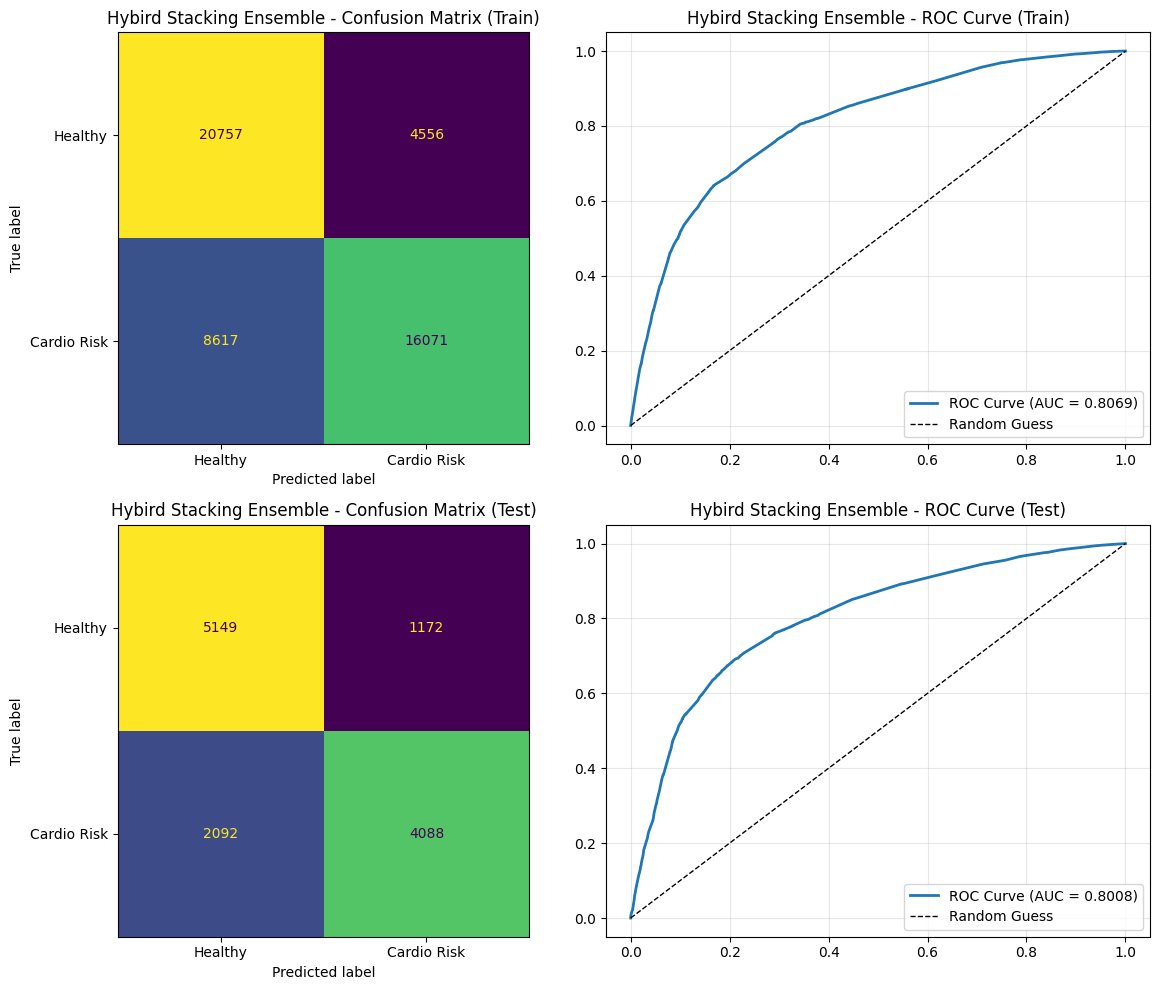

In [32]:
algorithm_name = 'Hybird Stacking Ensemble'
# ------------------------------
# Evaluasi Data Uji (Test)
# ------------------------------
y_pred_test = stacking_model_el.predict(x_test_np)
accuracy_test = accuracy_score(y_test_np, y_pred_test)
report_test = classification_report(y_test_np, y_pred_test, digits=4)

test_pred_prob = stacking_model_el.predict_proba(x_test_np)[:, 1]
auc_test = roc_auc_score(y_test_np, test_pred_prob)

print("Test Accuracy:", f"{accuracy_test:.4f}")
print("Test AUC:", f"{auc_test:.4f}")
print("\nTest Classification Report:\n", report_test)

# ------------------------------
# Evaluasi Data Latih (Train)
# ------------------------------
y_pred_train = stacking_model_el.predict(x_train_np)
accuracy_train = accuracy_score(y_train_np, y_pred_train)
report_train = classification_report(y_train_np, y_pred_train, digits=4)

train_pred_prob = stacking_model_el.predict_proba(x_train_np)[:, 1]
auc_train = roc_auc_score(y_train_np, train_pred_prob)

print("\nTrain Accuracy:", f"{accuracy_train:.4f}")
print("Train AUC:", f"{auc_train:.4f}")
print("\nTrain Classification Report:\n", report_train)

if accuracy_train > accuracy_test + 0.05 or auc_train > auc_test + 0.05:
    print("The model might be overfitting.")
else:
    print("No significant signs of overfitting.\n")

# ------------------------------
# Visualisasi Evaluasi (Train & Test)
# ------------------------------
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
display_labels = list(label_mapping.values()) if 'label_mapping' in globals() else None


cm_train = confusion_matrix(y_train_np, y_pred_train)
disp_train = ConfusionMatrixDisplay(confusion_matrix=cm_train, display_labels=display_labels)
disp_train.plot(ax=axes[0, 0], cmap='viridis', colorbar=False)
axes[0, 0].set_title(f"{algorithm_name} - Confusion Matrix (Train)")

fpr_train, tpr_train, _ = roc_curve(y_train_np, train_pred_prob)
axes[0, 1].plot(fpr_train, tpr_train, label=f"ROC Curve (AUC = {auc_train:.4f})", linewidth=2)
axes[0, 1].plot([0, 1], [0, 1], 'k--', label="Random Guess", linewidth=1)
axes[0, 1].set_title(f"{algorithm_name} - ROC Curve (Train)")
axes[0, 1].legend(loc="lower right")
axes[0, 1].grid(alpha=0.3)

cm_test = confusion_matrix(y_test_np, y_pred_test)
disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=display_labels)
disp_test.plot(ax=axes[1, 0], cmap='viridis', colorbar=False)
axes[1, 0].set_title(f"{algorithm_name} - Confusion Matrix (Test)")

fpr_test, tpr_test, _ = roc_curve(y_test_np, test_pred_prob)
axes[1, 1].plot(fpr_test, tpr_test, label=f"ROC Curve (AUC = {auc_test:.4f})", linewidth=2)
axes[1, 1].plot([0, 1], [0, 1], 'k--', label="Random Guess", linewidth=1)
axes[1, 1].set_title(f"{algorithm_name} - ROC Curve (Test)")
axes[1, 1].legend(loc="lower right")
axes[1, 1].grid(alpha=0.3)

plt.ticklabel_format(style='plain', axis='both', useOffset=False)
plt.tight_layout()
plt.show()

In [33]:
# import numpy as np
# from scipy.stats import pearsonr

# # Misal, prediksi probabilitas dari base model disimpan dalam dictionary
# # Prediksi base model harus berupa array 1 dimensi (misalnya, probabilitas kelas positif)
# preds_lgbm = lgbm_model.predict_proba(x_test_np)[:, 1]
# preds_cat = catb_model.predict_proba(x_test_np)[:, 1]
# preds_hgrb = hgrb_model.predict_proba(x_test_np)[:, 1]
# preds_tabnet = tabnet_model.predict_proba(x_test_np)[:, 1]

# # Menyimpan semua prediksi di dalam array
# all_preds = np.vstack([preds_lgbm, preds_cat, preds_hgrb, preds_tabnet])

# # Menghitung korelasi antar model
# n_models = all_preds.shape[0]
# for i in range(n_models):
#     for j in range(i+1, n_models):
#         corr_coef, _ = pearsonr(all_preds[i], all_preds[j])
#         print(f"Korelasi antara model {i} dan model {j}: {corr_coef:.3f}")


In [34]:
# numerical_features = ['age', 'height', 'weight', 'systolic', 'diastolic', 'bmi', 'map', 'pulse_pressure']

# preprocessor = ColumnTransformer(
#     transformers=[
#         ('num', StandardScaler(), numerical_features)
#     ],
#     remainder='passthrough' 
# )

# pipeline = Pipeline(steps=[
#     ('preprocessor', preprocessor),
#     ('classifier', stacking_model)
# ])

# pipeline.fit(X_train, y_train)

# with open("pkl/ml_ensemble_model.pkl", "wb") as f:
#     pickle.dump(pipeline, f)

# print("Pipeline telah disimpan dalam file 'ml_ensemble_model_v2.pkl'.")

In [35]:
# with open('pkl/ml_ensemble_model.pkl', 'rb') as f:
#     loaded_model = pickle.load(f)

# # Lakukan prediksi menggunakan CPU
# y_pred = loaded_model.predict(X_test)

# # Menghitung dan menampilkan accuracy score
# acc = accuracy_score(y_test, y_pred)
# print("Akurasi model:", acc)

In [36]:
# data_new = {
#     'age':       [30, 35, 40, 45, 50, 60, 65, 70, 55, 68],   
#     'height':    [175, 180, 170, 165, 160, 158, 155, 150, 165, 160], 
#     'weight':    [68, 75, 72, 80, 85, 90, 95, 100, 78, 82], 
#     'systolic':  [110, 115, 120, 125, 130, 140, 150, 160, 115, 135],  
#     'diastolic': [70, 75, 80, 85, 90, 95, 100, 105, 75, 88],         
#     'gender':       [0, 0, 1, 0, 1, 1, 1, 1, 0, 1], # gender: 0 untuk nilai asli 1, 1 untuk nilai asli 2
#     'cholesterol':  [0, 0, 1, 1, 2, 2, 2, 2, 0, 2], # cholesterol: 0 untuk nilai asli 1, 1 untuk nilai asli 2, 2 untuk nilai asli 3
#     'gluc':         [0, 0, 1, 1, 1, 2, 2, 2, 0, 2], # gluc: 0 untuk nilai asli 1, 1 untuk nilai asli 2, 2 untuk nilai asli 3
#     'smoke':        [0, 0, 0, 0, 1, 1, 1, 1, 0, 1],
#     'alco':         [0, 0, 0, 0, 0, 1, 1, 1, 0, 1],
#     'active':       [1, 1, 1, 1, 0, 0, 0, 0, 1, 0]
# }

# new_df = pd.DataFrame(data_new)

# valid_gender      = new_df['gender'].isin([0, 1])
# valid_cholesterol = new_df['cholesterol'].isin([0, 1, 2])
# valid_gluc        = new_df['gluc'].isin([0, 1, 2])
# valid_smoke       = new_df['smoke'].isin([0, 1])
# valid_alco        = new_df['alco'].isin([0, 1])
# valid_active      = new_df['active'].isin([0, 1])

# if not (valid_gender.all() and valid_cholesterol.all() and valid_gluc.all() and 
#         valid_smoke.all() and valid_alco.all() and valid_active.all()):
#     raise ValueError("Terdapat nilai kategori yang tidak valid pada input data.")

# new_df["bmi"] = round(new_df["weight"] / ((new_df["height"] / 100) ** 2), 2)
# new_df["map"] = round((new_df["systolic"] + 2 * new_df["diastolic"]) / 3, 2)
# new_df["pulse_pressure"] = new_df["systolic"] - new_df["diastolic"]

# expected_order = [
#     'age', 'height', 'weight', 'systolic', 'diastolic', 
#     'bmi', 'map', 'pulse_pressure',
#     'gender', 'cholesterol', 'gluc', 'smoke', 'alco', 'active'
# ]
# new_df = new_df[expected_order]

# with open("pkl/ml_ensemble_model.pkl", "rb") as f:
#     pipeline = pickle.load(f)

# predictions = pipeline.predict(new_df)

# print("Input Data Baru (setelah pembuatan fitur turunan dan validasi):")
# print(new_df)
# print("\nHasil Prediksi untuk 10 contoh data:")
# print("Prediksi status cardio untuk data baru:", predictions)


In [37]:
# stacking_results = evaluate_model(stacking_model, x_train_np, y_train, x_test_np, y_test, "Stacking Ensemble Classifier")
# stacking_results;

In [38]:
# results = [lgbm_results, xgb_results, catb_results, 
#         snb_results, grb_results, hgrb_results, stacking_results
#         ]

# create_summary_table(results)